In [18]:
!pip3 install pyclustering prettytable

You should consider upgrading via the 'C:\Users\Alessandro\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer

In [3]:
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

ModuleNotFoundError: No module named 'google'

In [4]:
DATA_PATH = '/content/drive/Shareddrives/DM_tweets/data/'

In [5]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [6]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [7]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None, filter=None):
    #cent = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(df[attr1], df[attr2], c=c_labels)

    if filter:
        df = df.loc[filter]
        c_labels = c_labels[filter]

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

    plt.tick_params(axis='both', which='major')
    if filename != None:
        plt.savefig(filename)
    else:
        plt.show()


In [8]:
def get_metrics(data_scaled, labels, print_out=True):
    silohuette = metrics.silhouette_score(data_scaled, labels)
    DBscore = metrics.davies_bouldin_score(data_scaled, labels)
    if print_out:
        print(f"Silouhette score: {silohuette}")  # [-1, 1] Good when near 1
        print(f"Davies Bouldin score: {DBscore}")  # Good when near 0
    else:
        return silohuette, DBscore


In [36]:
def plots(df, labels, path=None, centroids=None, attributes=None):
  if attributes is None:
    attributes = df.columns
  
  # Line plot
  plt.figure(figsize=(50, 5))
  for label in np.unique(labels):
    if centroids is None:
      cent = df[attributes][labels == label].median()
    else:   
      cent = centroids[label]
    plt.plot(cent, label="Cluster %s" % label)
  plt.tick_params(axis='both', which='major')
  plt.xticks(range(0, len(df[attributes].columns)), df[attributes].columns)
  plt.legend()
  plt.show()
  if path is not None:
    plt.savefig(path + "/landscape.png")

  # Radar plot
  N = len(attributes)

  plt.figure(figsize=(8, 8))
  for label in np.unique(labels):
      angles = [n / float(N) * 2 * math.pi for n in range(N)]
      if centroids is None:
        values = df[attributes].loc[np.where(labels == label)].median().tolist()
      else:
        values = centroids[label].tolist()
      values += values[:1]
      angles += angles[:1]

      ax = plt.subplot(polar=True)
      plt.xticks(angles[:-1], attributes)
      ax.plot(angles, values, linewidth=2)
      ax.fill(angles, values, 'b', alpha=0.1)

  plt.savefig(path + "/radar.png")

  # Plot w.r.t. languages
  lang_ct = pd.crosstab(labels, df['lang'])

  fig, ax = plt.subplots(figsize=(46, 15))
  lang_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('lang')
  plt.yscale('log')
  plt.legend(prop={'size': 15})
  plt.show()
  plt.savefig(path + "/lang_characterization.png")

  # Plot w.r.t. bots
  bot_ct = pd.crosstab(labels, df['bot'])

  fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
  #plt.figure(figsize=(10,25))
  bot_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('bot')
  plt.legend(prop={'size': 30})
  plt.show()
  plt.savefig(path + "/bot_characterization.png")


In [10]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              140543 non-null  object 
 1   2012_tweets          140543 non-null  int64  
 2   2013_tweets          140543 non-null  int64  
 3   2014_tweets          140543 non-null  int64  
 4   2015_tweets          140543 non-null  int64  
 5   2016_tweets          140543 non-null  int64  
 6   2017_tweets          140543 non-null  int64  
 7   2018_tweets          140543 non-null  int64  
 8   2019_tweets          140543 non-null  int64  
 9   2020_tweets          140543 non-null  int64  
 10  mean_length          140543 non-null  float64
 11  retweets_count_mean  140543 non-null  float64
 12  retweets_count_std   13781 non-null   float64
 13  reply_count_mean     140543 non-null  float64
 14  favorite_count_mean  140543 non-null  float64
 15  num_hashtags_mean

In [11]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [12]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11504 non-null  object 
 8   2012_tweets          11504 non-null  float64
 9   2013_tweets          11504 non-null  float64
 10  2014_tweets          11504 non-null  float64
 11  2015_tweets          11504 non-null  float64
 12  2016_tweets          11504 non-null  float64
 13  2017_tweets          11504 non-null  float64
 14  2018_tweets          11504 non-null  float64
 15  2019_tweets          11504 non-null 

In [13]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'created_at', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

Drop categorical columns

In [14]:
# Replace NaN values in variance with 0 
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge[numeric_attributes]
df_merge_log = df_merge_log.fillna(value=0)
#df_merge.drop(columns=['created_at_conv', 'created_at_mean'], inplace=True)

# Normalization of values

In [15]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [16]:
for attr in numeric_attributes:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30332\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [19]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+---------------------+--------------------+--------------------+
|         attr        |        min         |        max         |
+---------------------+--------------------+--------------------+
|    statuses_count   |        0.0         | 12.898106706802647 |
|   created_at_conv   | 41.72973140916386  | 41.90866321880304  |
|     2012_tweets     |        0.0         | 1.9459101490553132 |
|     2013_tweets     |        0.0         | 5.1298987149230735 |
|     2014_tweets     |        0.0         | 6.785587645007929  |
|     2015_tweets     |        0.0         | 7.436617265234227  |
|     2016_tweets     |        0.0         | 7.945909598613133  |
|     2017_tweets     |        0.0         | 8.086410275323782  |
|     2018_tweets     |        0.0         |  8.07153089355666  |
|     2019_tweets     |        0.0         |  8.11969625295725  |
|     2020_tweets     |        0.0         | 8.116715624819111  |
|     mean_length     |        0.0         | 5.501258210544727  |
| retweets

In [20]:
# Normalizzare i valori in log
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

In [21]:
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [22]:
df_merge_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  float64
 2   2012_tweets          11508 non-null  float64
 3   2013_tweets          11508 non-null  float64
 4   2014_tweets          11508 non-null  float64
 5   2015_tweets          11508 non-null  float64
 6   2016_tweets          11508 non-null  float64
 7   2017_tweets          11508 non-null  float64
 8   2018_tweets          11508 non-null  float64
 9   2019_tweets          11508 non-null  float64
 10  2020_tweets          11508 non-null  float64
 11  mean_length          11508 non-null  float64
 12  retweets_count_mean  11508 non-null  float64
 13  retweets_count_std   11508 non-null  float64
 14  reply_count_mean     11508 non-null  float64
 15  favorite_count_mean  11508 non-null 

# DB Scan

In [23]:
dist = pdist(df_merge_scaled[numeric_attributes], 'euclidean')
dist_matrix = squareform(dist)

First we compute the distance matrix to choose the epsilon parameter.
We choose quite a high k since we have a considerably high amount of samples and high dimensionality

In [24]:
distances = list()
k = 20
for d in dist_matrix:
    index_kth_distance = np.argsort(d)[k]
    distances.append(d[index_kth_distance])

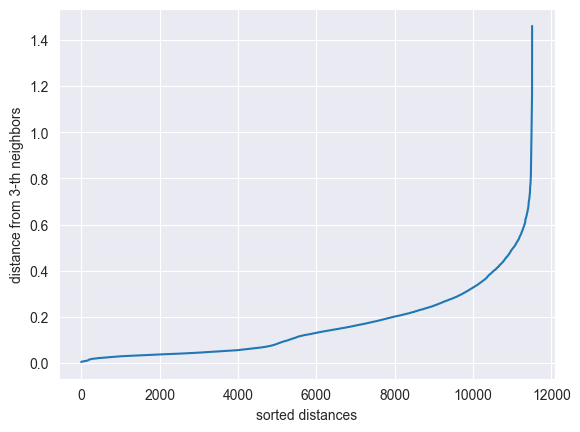

In [25]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')
plt.show()

The knee of the curve is around 0.3, so values around this point will be investigated. Interstingle, our curve bens in the 0.1 neighborhood, hence also this zone is worth investigating.

In [26]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+-------+----------------------+--------------------+------------+
|  eps  |      silohuette      |      DB score      | n clusters |
+-------+----------------------+--------------------+------------+
| 0.075 | 0.08159689514003385  | 1.1618571666353017 |     12     |
|  0.1  | 0.028954194770931904 | 1.1219824407733967 |     12     |
| 0.125 |  0.0890672049370497  | 1.1255252949914945 |     13     |
|  0.15 |  0.1877714981341073  | 1.1923044713498852 |     17     |
| 0.175 |  0.257814745089147   | 1.2342269629440126 |     19     |
|  0.2  | 0.33544815398847144  | 1.283763928754722  |     18     |
| 0.225 |  0.3558523370818563  | 1.2800714475343578 |     13     |
|  0.25 |  0.3804363673754632  | 1.3151529402818918 |     12     |
| 0.275 |  0.4191083029512266  | 1.3177547884199967 |     11     |
|  0.3  | 0.41545129592994107  | 1.2521401879980587 |     13     |
| 0.325 |  0.3894192545015634  | 1.323768482314448  |     9      |
+-------+----------------------+--------------------+---------

The zone around 0.3 seems the more promising.

In [27]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.28, 0.29, 0.3, 0.31]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+------+---------------------+--------------------+------------+
| eps  |      silohuette     |      DB score      | n clusters |
+------+---------------------+--------------------+------------+
| 0.28 | 0.38708113164324115 | 1.307892425654708  |     12     |
| 0.29 | 0.41224775268875646 | 1.242517510584001  |     12     |
| 0.3  | 0.41545129592994107 | 1.2521401879980587 |     13     |
| 0.31 |  0.380283411590873  | 1.2771945879577478 |     11     |
+------+---------------------+--------------------+------------+


In [28]:
dbscan = DBSCAN(eps=0.29, min_samples=42)
clusters = dbscan.fit(df_merge_scaled[numeric_attributes])

In [29]:
try:
  os.mkdir('dbscan')
except:
  pass

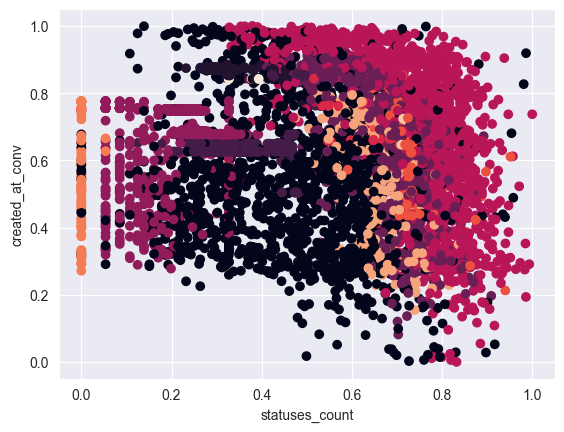

In [30]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'created_at_conv', clusters.labels_)

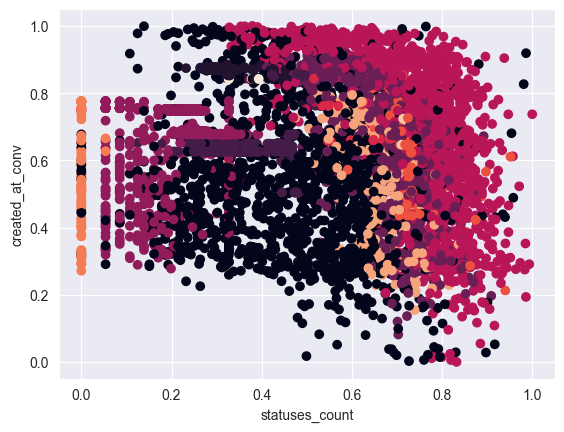

In [31]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'created_at_conv', clusters.labels_,
            filter=np.where(clusters.labels_ != -1))

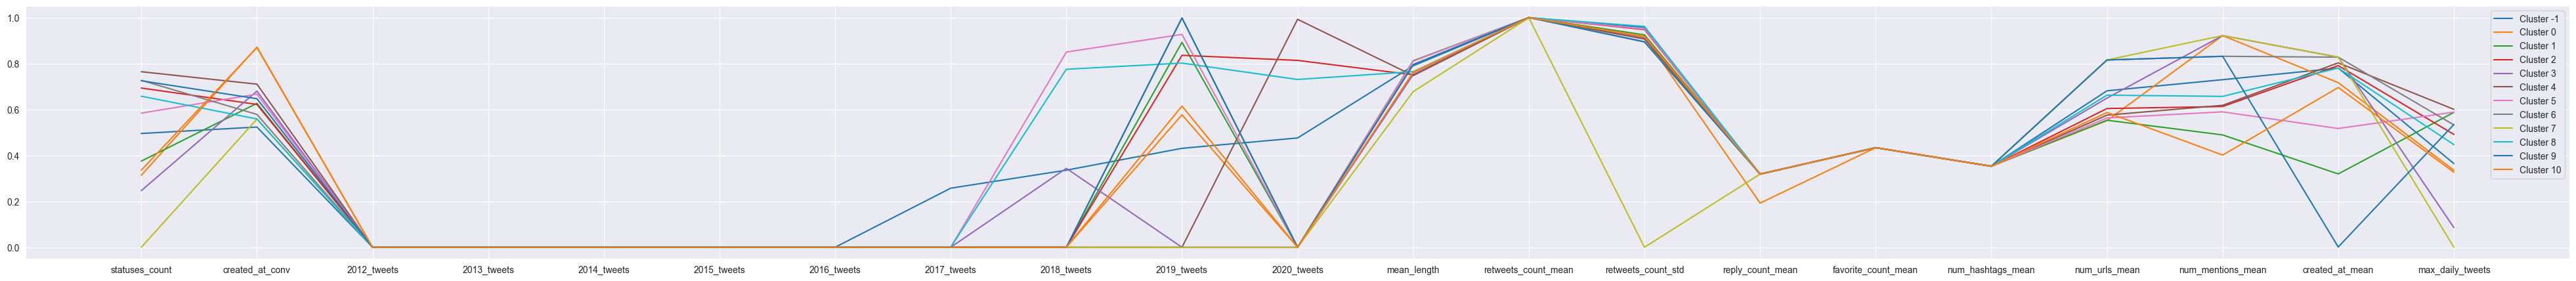

<Figure size 640x480 with 0 Axes>

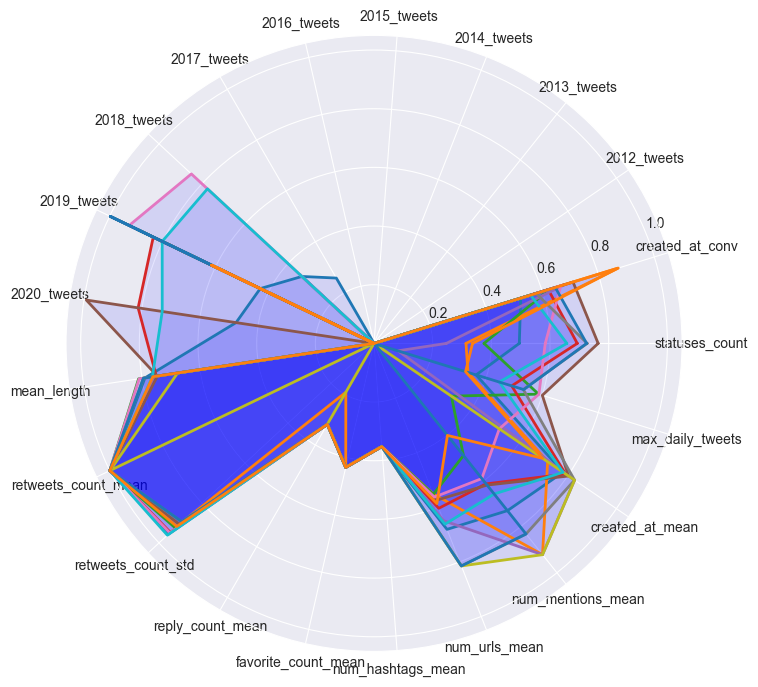

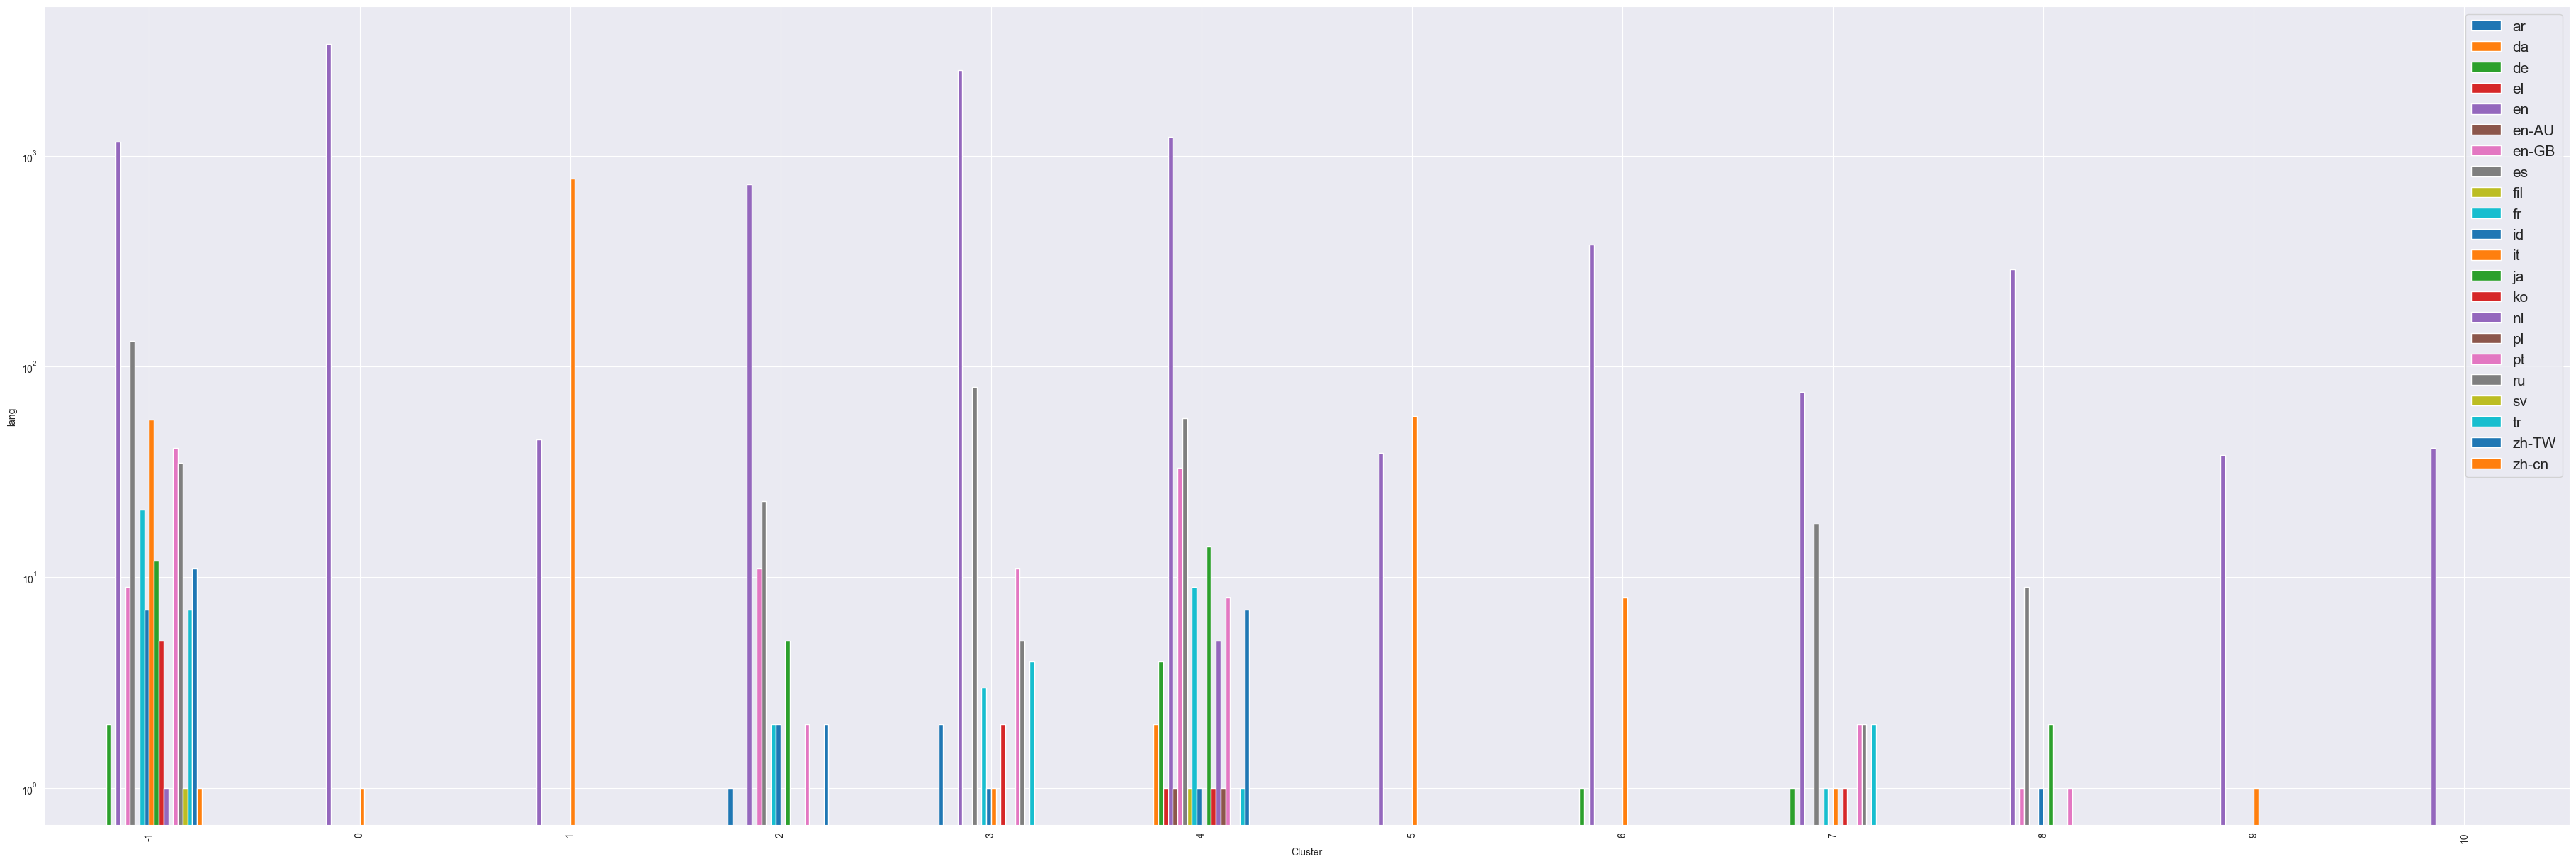

<Figure size 640x480 with 0 Axes>

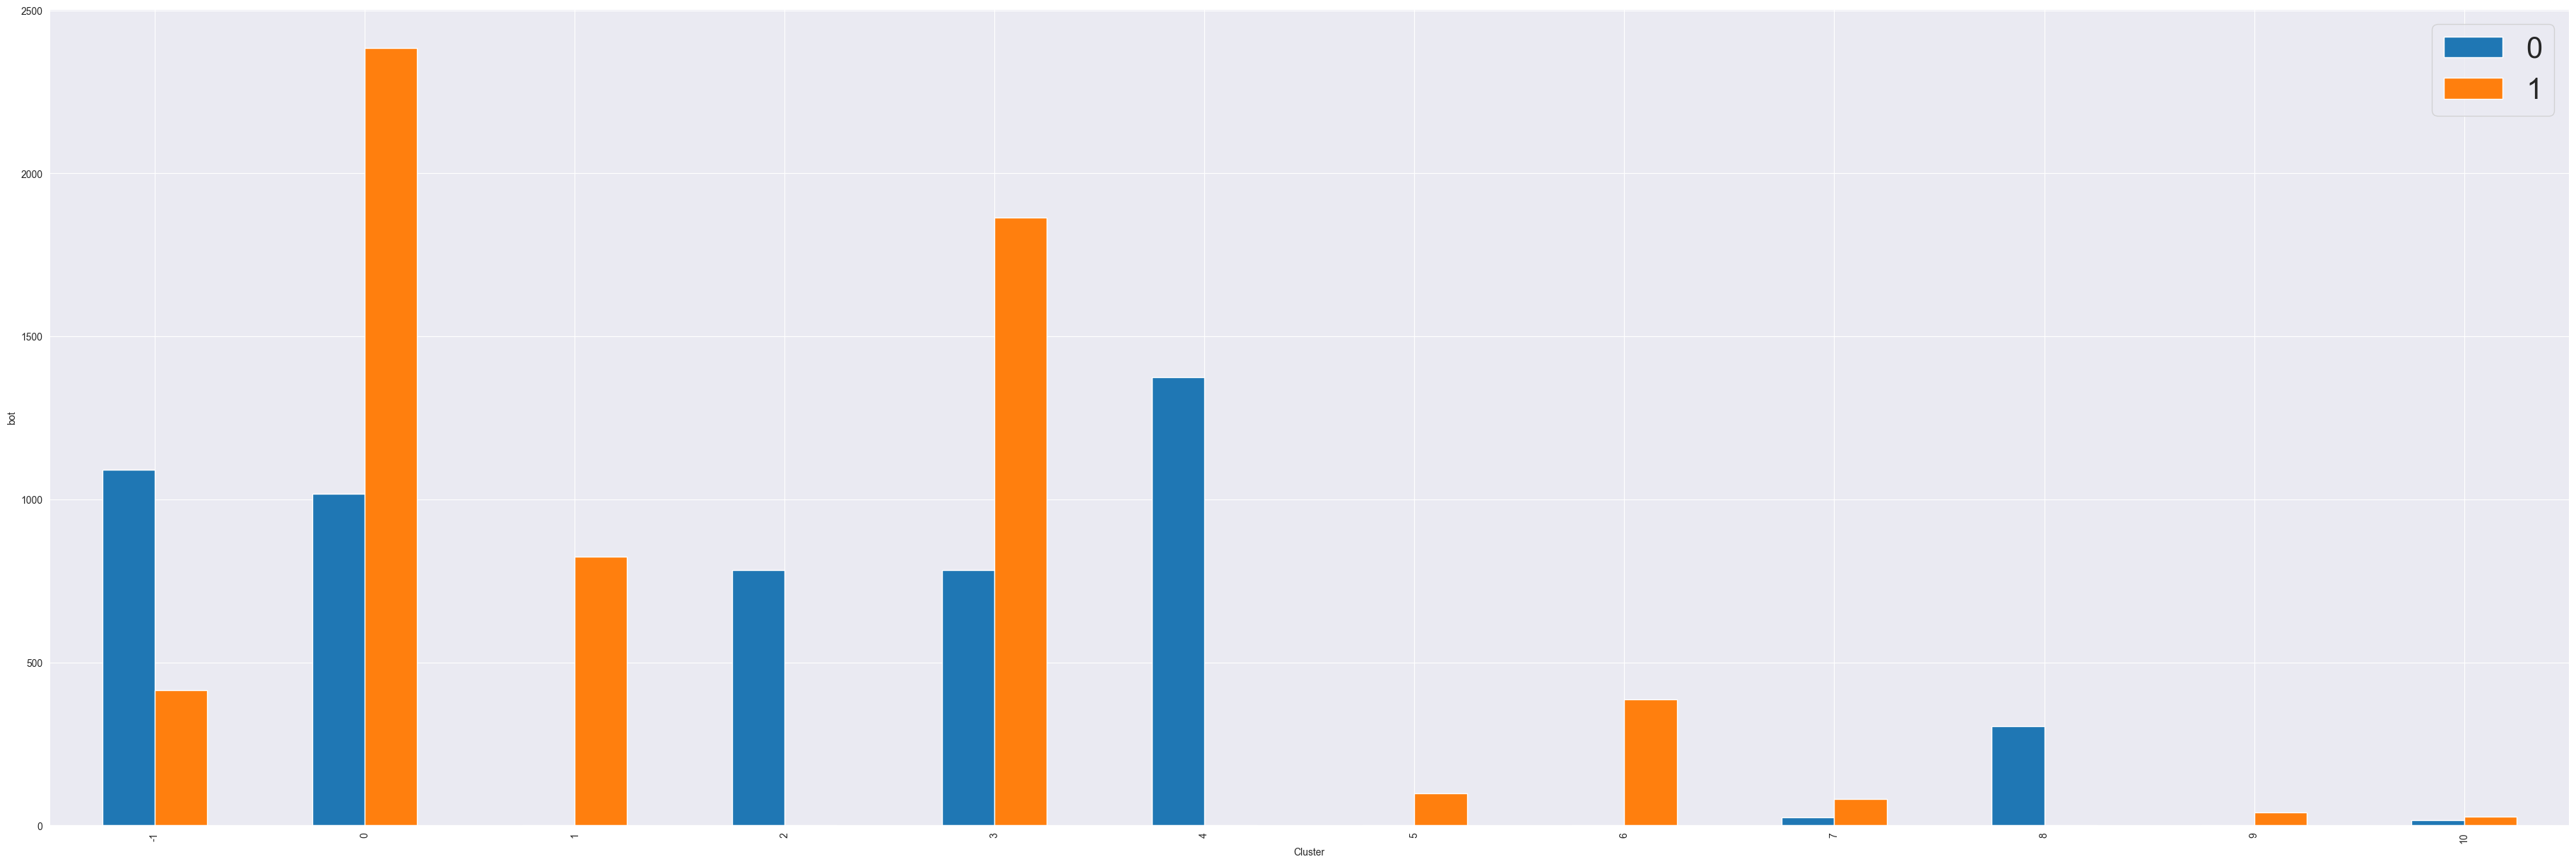

<Figure size 640x480 with 0 Axes>

In [37]:
plots(df_merge_scaled, clusters.labels_, path="dbscan", attributes=numeric_attributes)

In [38]:
df_denoised = df_merge_scaled[clusters.labels_!=-1]

# KMeans

In [39]:
try:
  os.mkdir('kmeans')
except:
  pass

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [40]:
def find_optimal_k(df, max_k=40):
    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(df)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

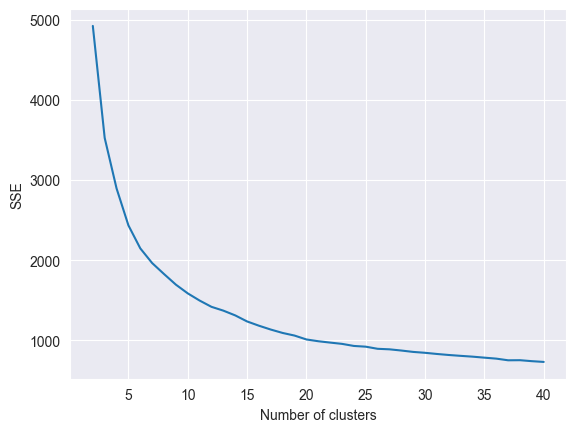

In [41]:
find_optimal_k(df_merge_scaled[numeric_attributes])

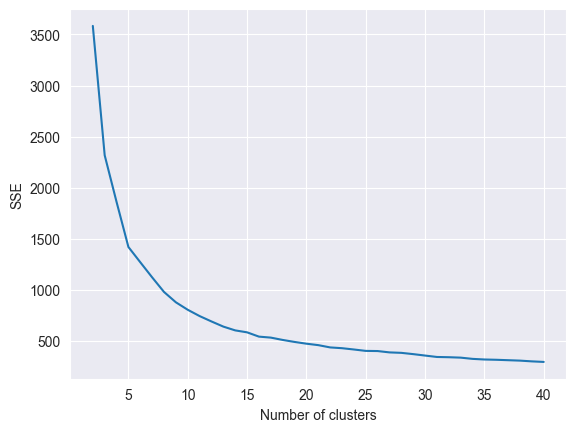

In [42]:
find_optimal_k(df_denoised[numeric_attributes])

The optimal number of clusters seems to be around 10.

In [43]:
def kmeans_analysis(df, k, n_init=20, max_iter=300, out_dir=None, combinations=False):
    try:
        os.mkdir(out_dir)
    except FileExistsError:
        pass

    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(df[numeric_attributes])
    cent = kmeans.cluster_centers_

    print(f'SSE:', kmeans.inertia_)
    get_metrics(df[numeric_attributes], kmeans.labels_)

    if combinations:
        try:
            os.mkdir(os.path.join(out_dir, 'combinations'))
        except FileExistsError:
            pass
        combs = combinations(df[numeric_attributes].columns, 2)
        os.mkdir('kmeans')
        os.mkdir('kmeans/log_denoised')
        for comb in combs:
            plt.ylabel(comb[1])
            plt.xlabel(comb[0])
            print(*comb)
            scatterplot(df, *comb, kmeans.labels_, centroids=cent,
                        filename=os.path.join(out_dir, 'combinations', f"scatterplot_{comb[1]}_{comb[0]}.png"))
    else:
        scatterplot(df, 'created_at_conv', 'statuses_count', kmeans.labels_,
                    centroids=cent, filename=os.path.join(out_dir, "clusters"))

    plots(df, kmeans.labels_, path = out_dir, centroids = cent, attributes=numeric_attributes)

SSE: 1593.3159190400993
Silouhette score: 0.45890292967340357
Davies Bouldin score: 1.2261468650145242


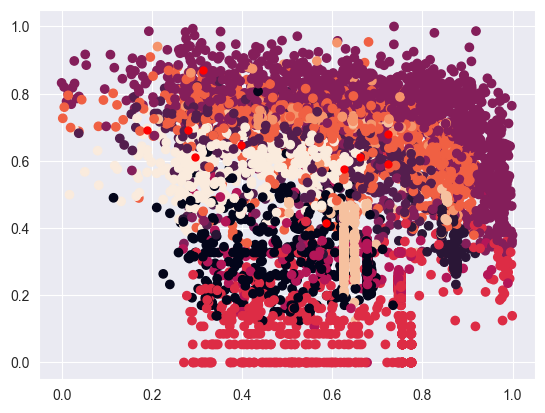

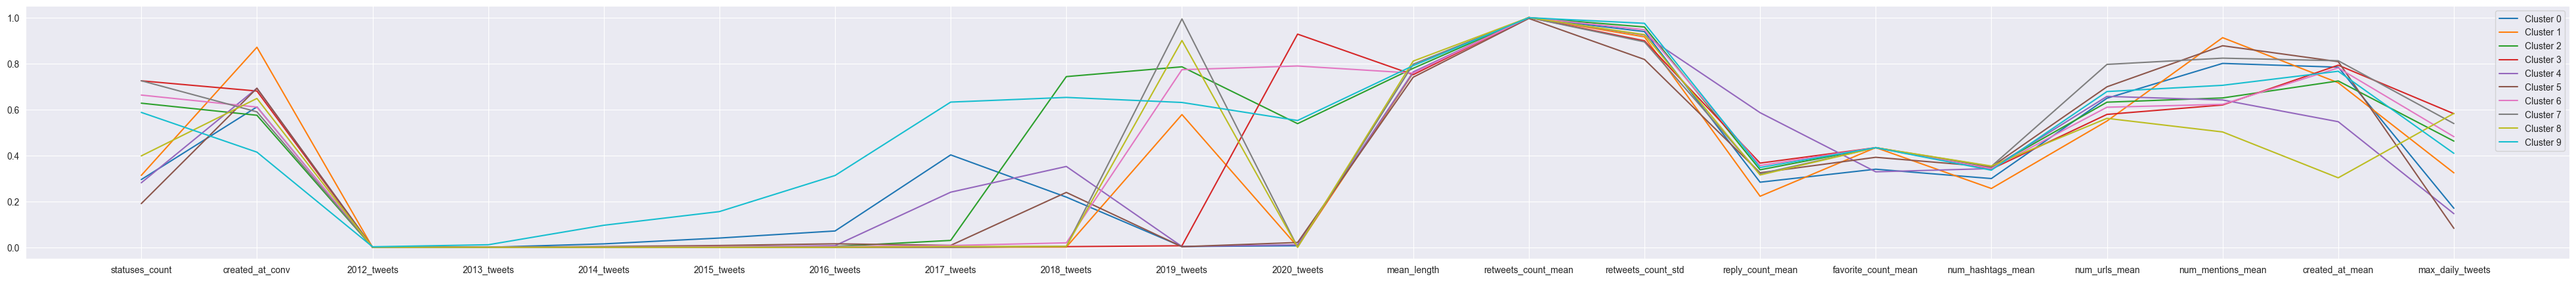

<Figure size 640x480 with 0 Axes>

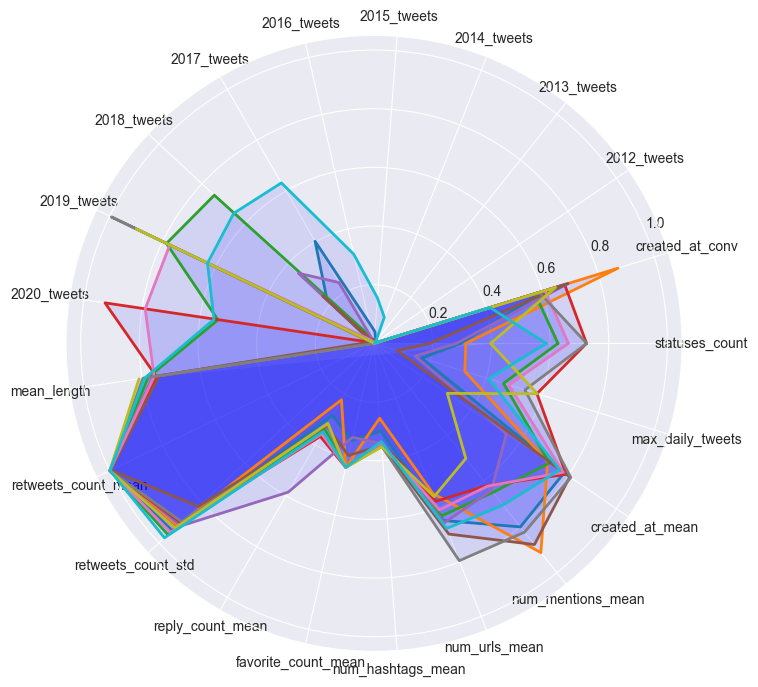

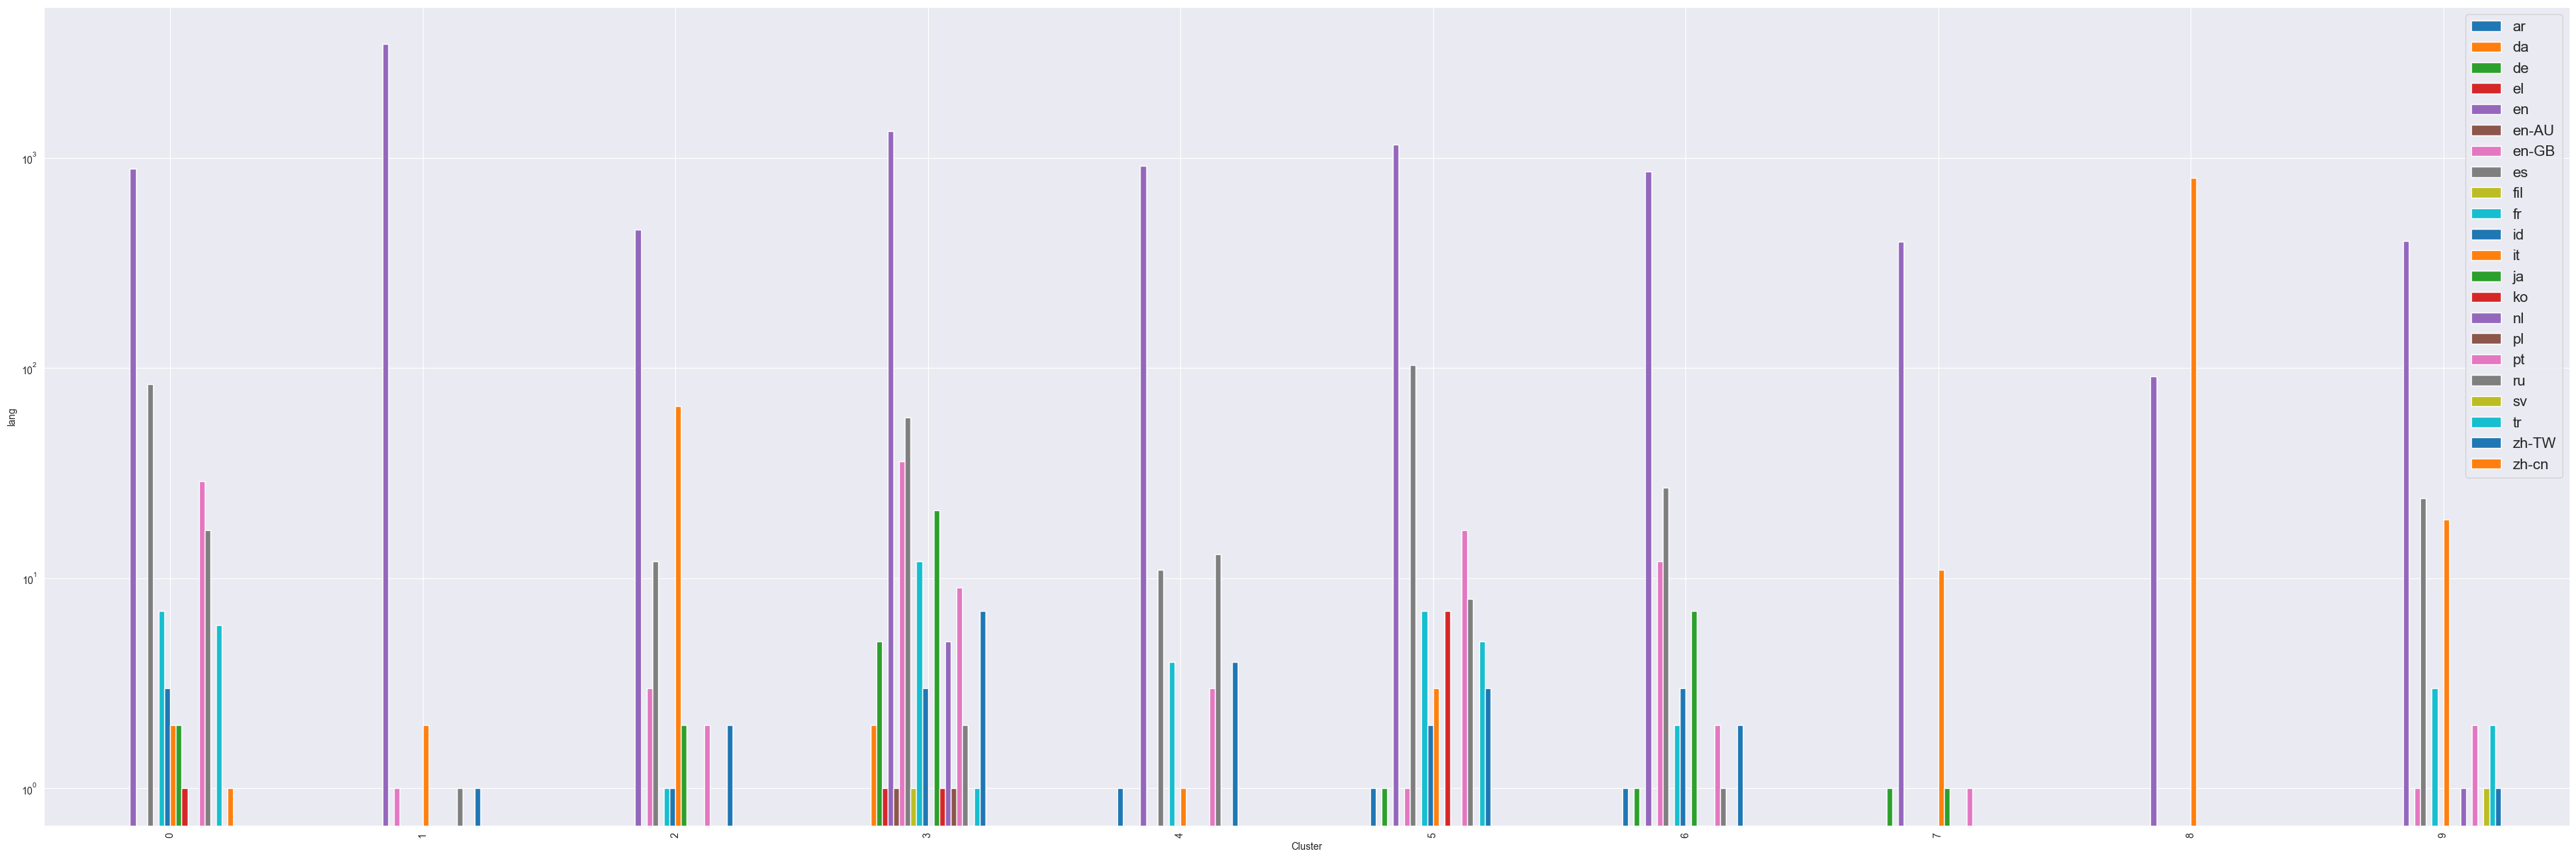

<Figure size 640x480 with 0 Axes>

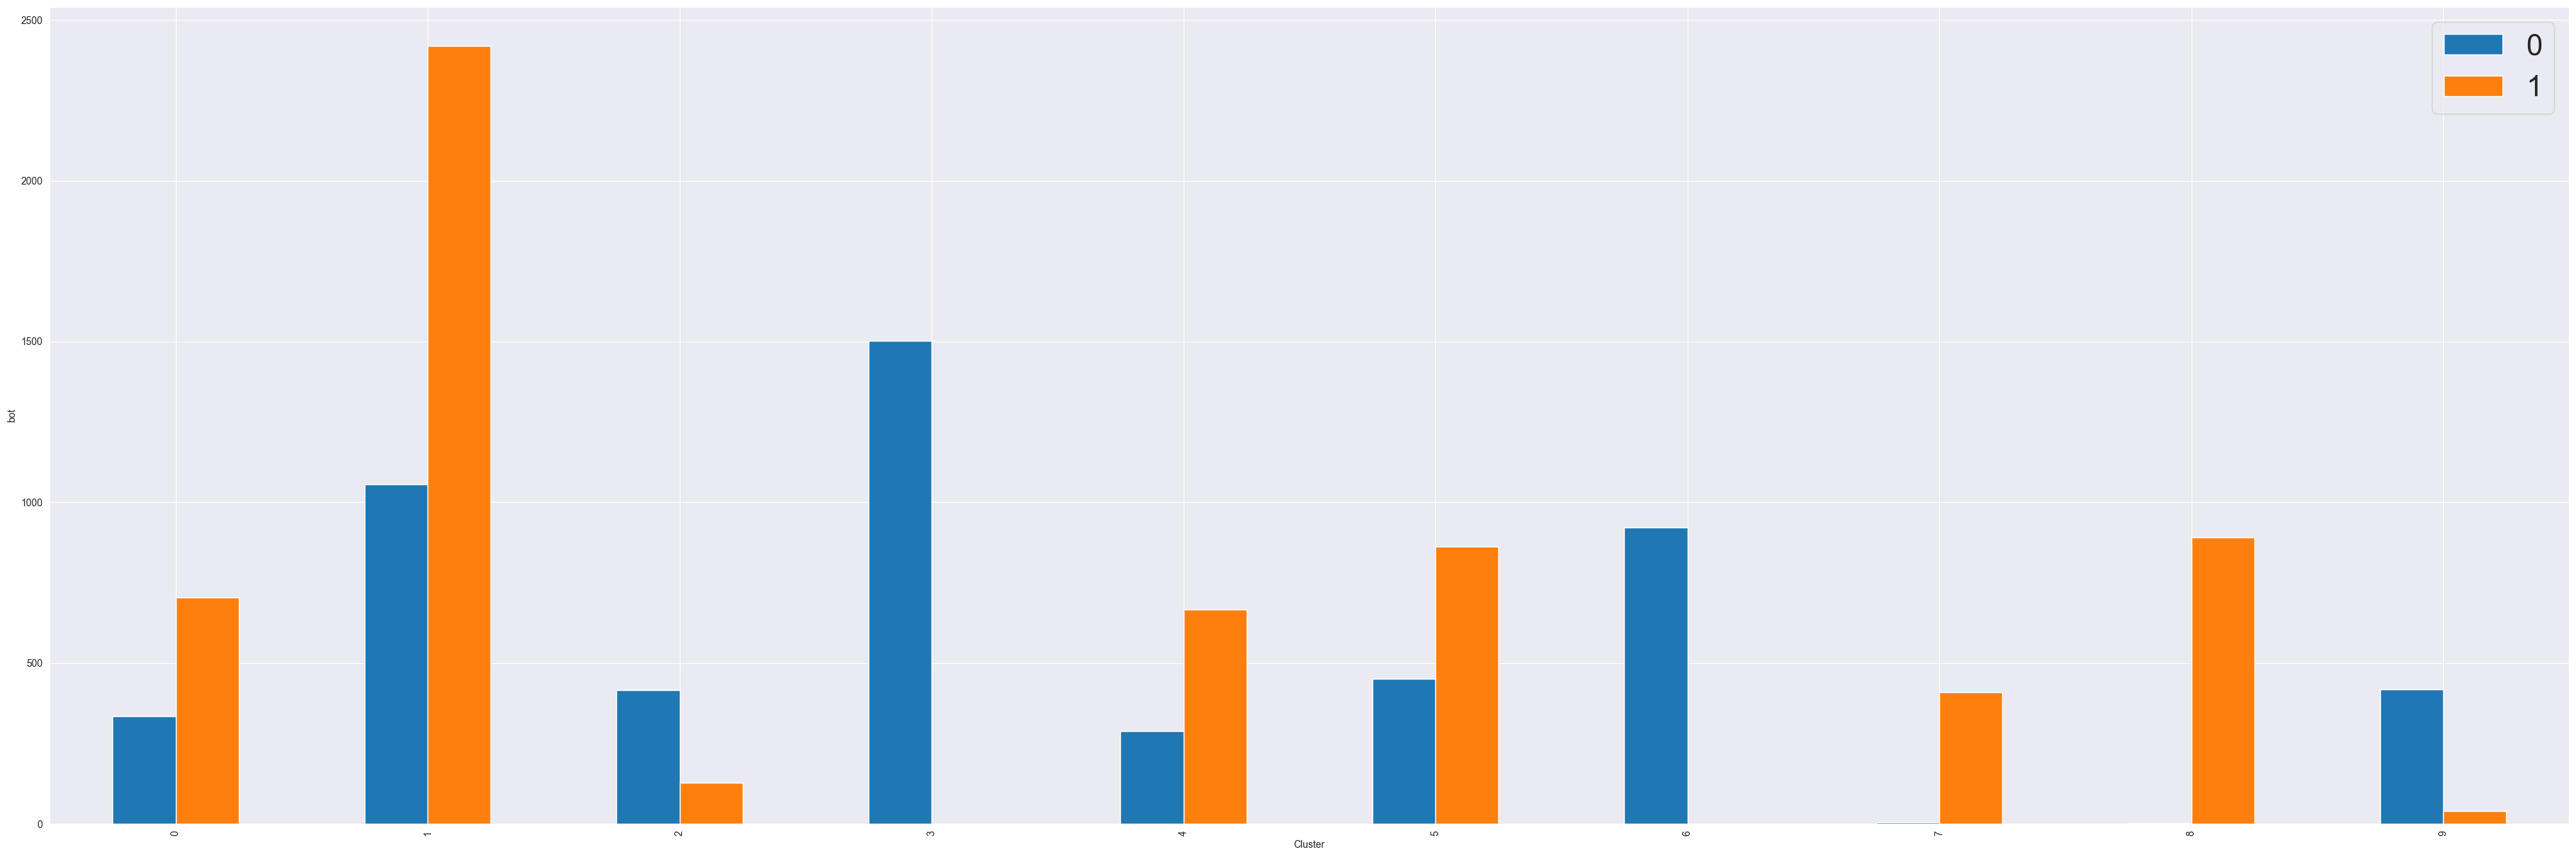

<Figure size 640x480 with 0 Axes>

In [44]:
kmeans_analysis(df_merge_scaled, k=10, out_dir='kmeans/scaled_k10')

SSE: 1122.7599800480264
Silouhette score: 0.5122081730297648
Davies Bouldin score: 1.0242155378699827


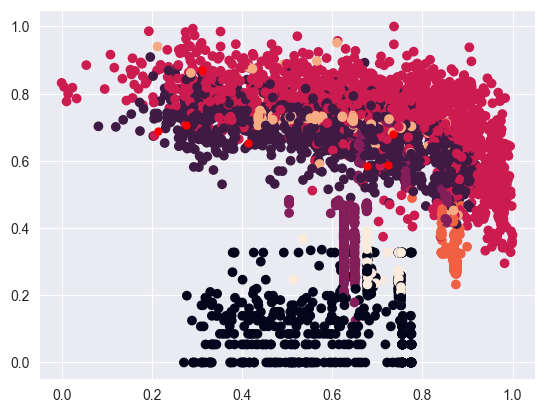

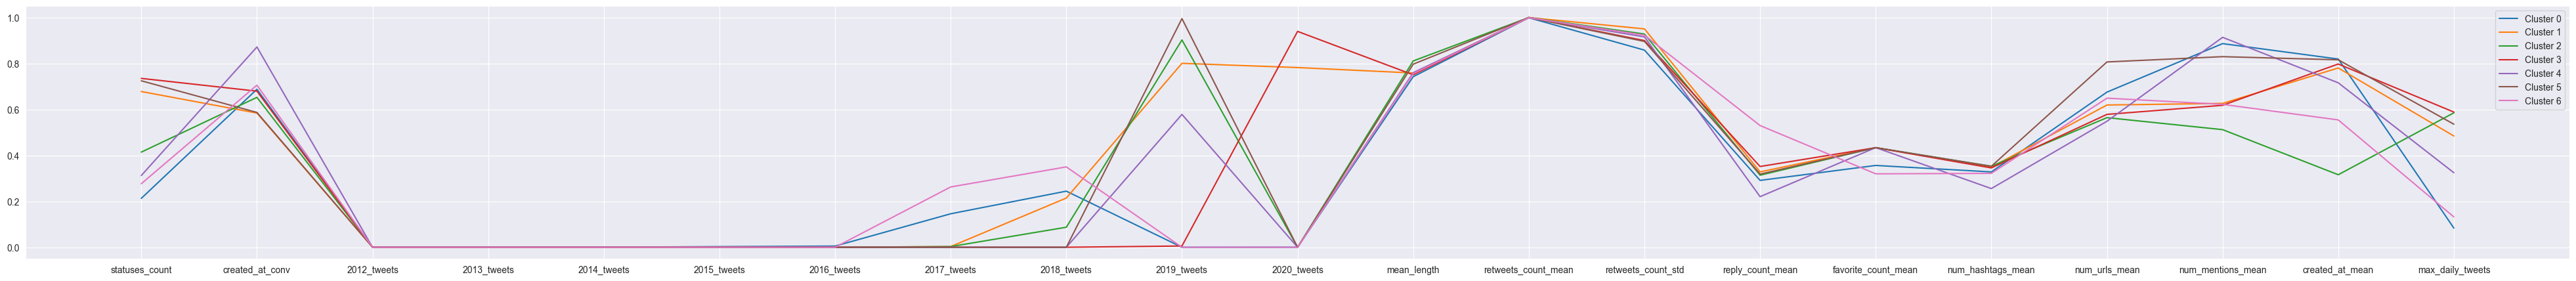

<Figure size 640x480 with 0 Axes>

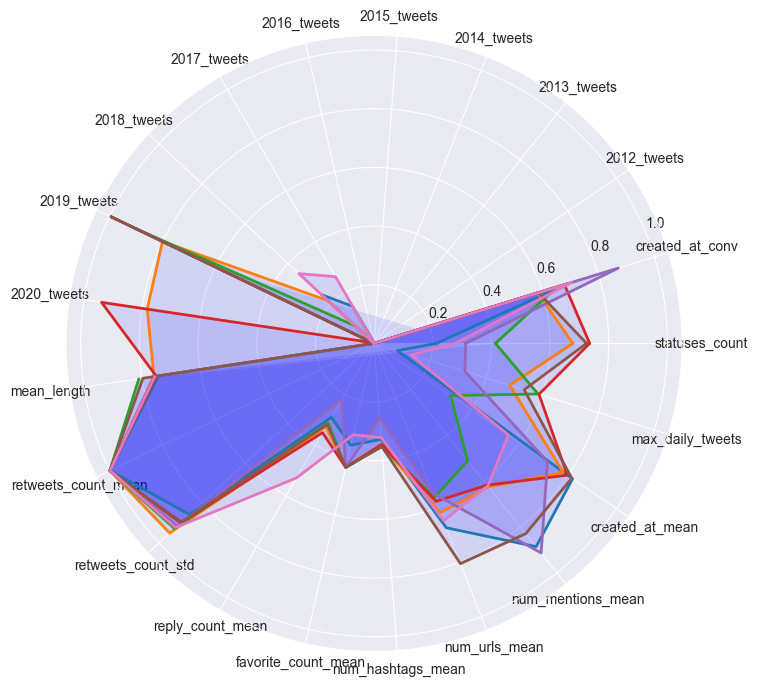

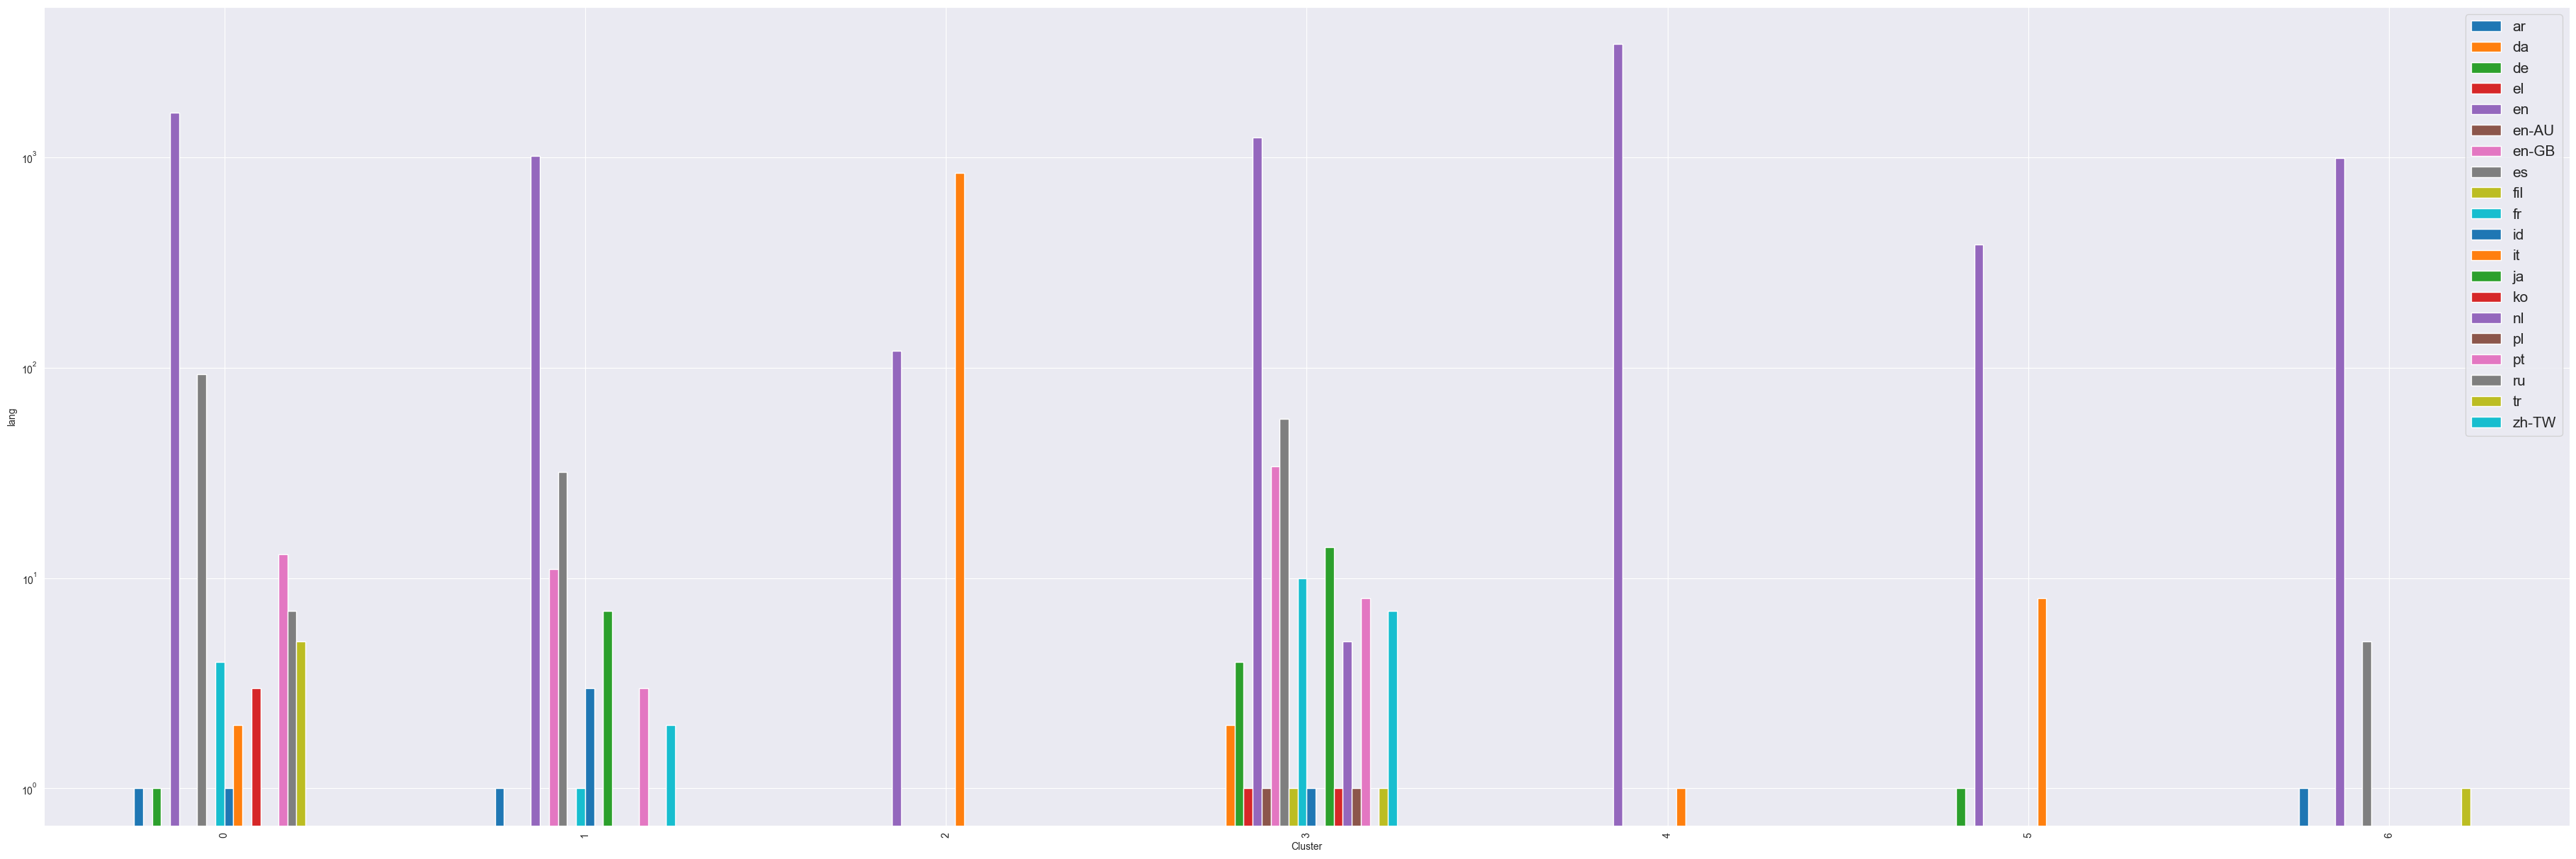

<Figure size 640x480 with 0 Axes>

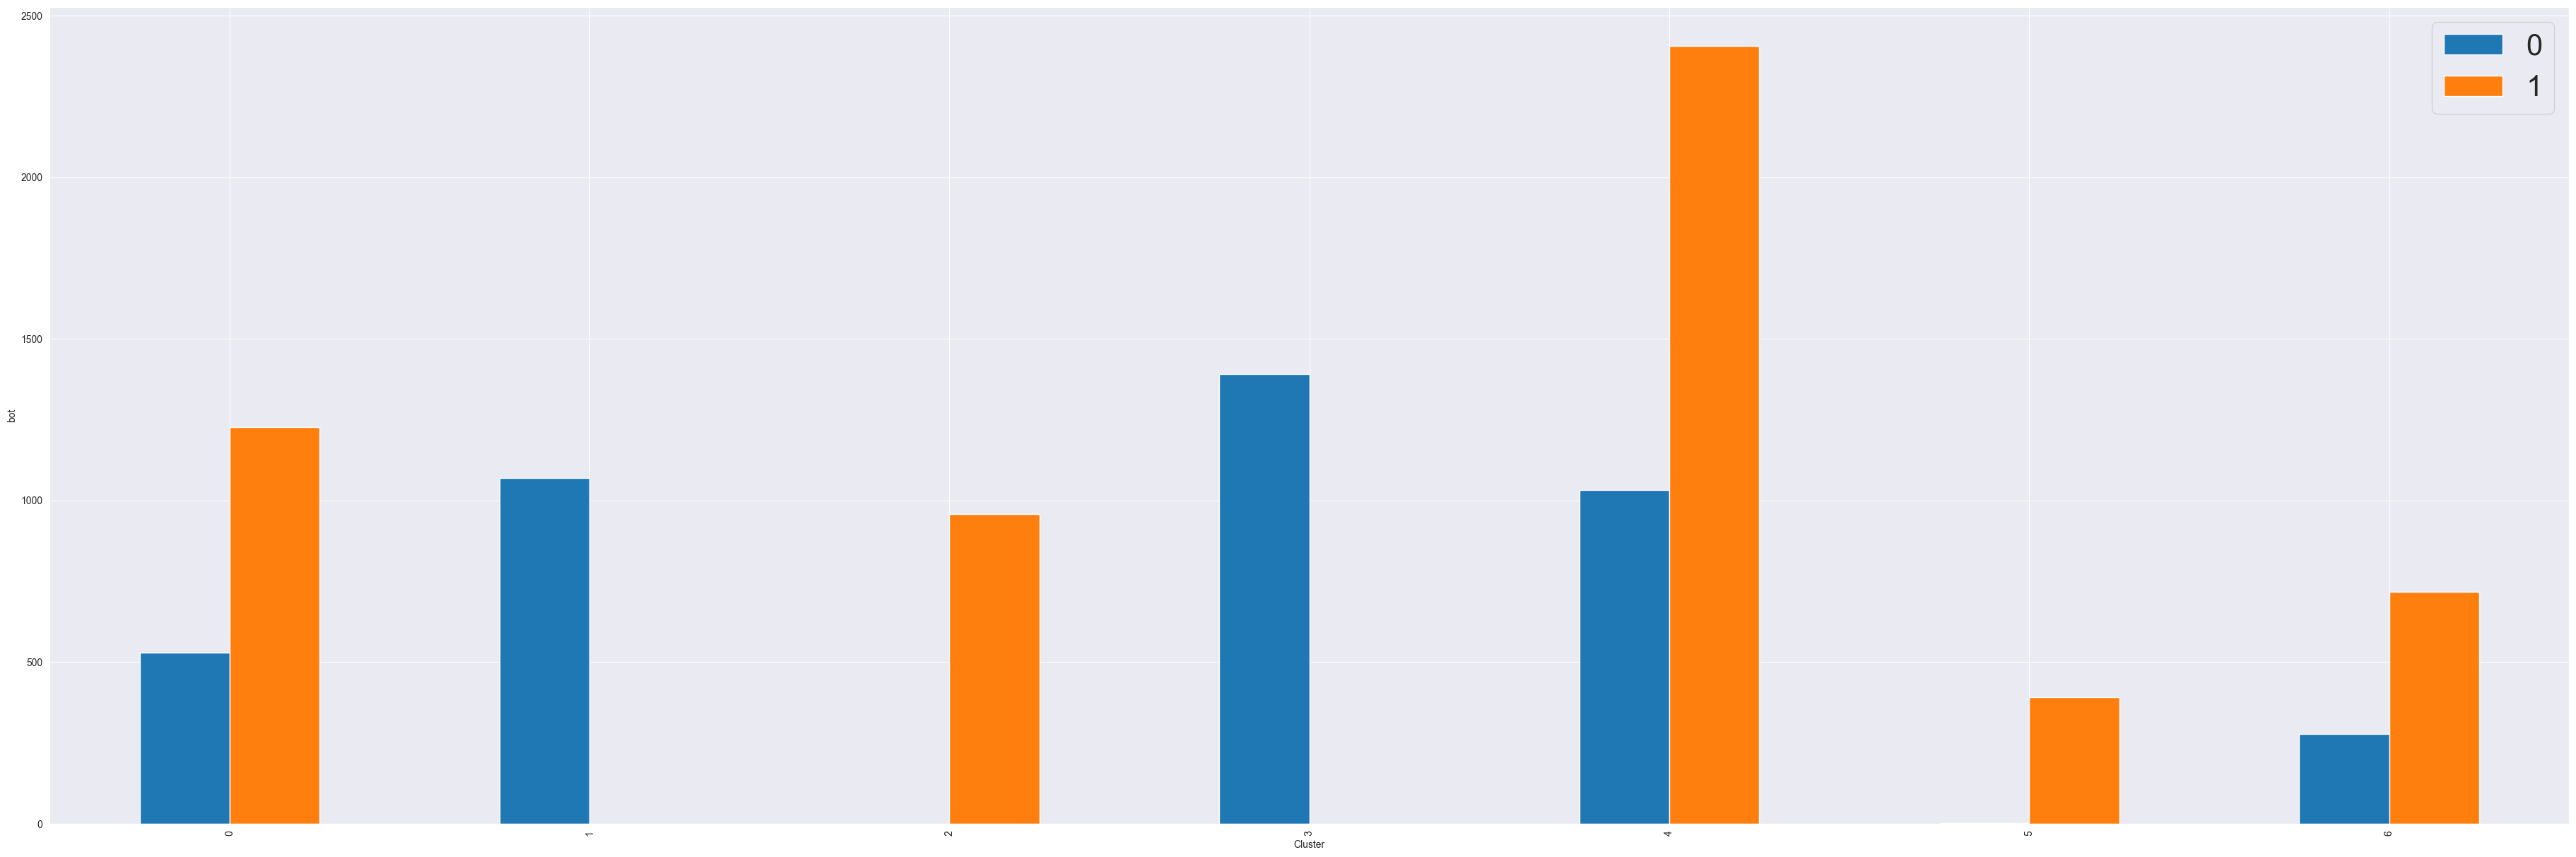

<Figure size 640x480 with 0 Axes>

In [45]:
kmeans_analysis(df_denoised, k=7, out_dir='kmeans/denoised_k7')

SSE: 979.9203324064931
Silouhette score: 0.5265355737877931
Davies Bouldin score: 0.9629460508378527


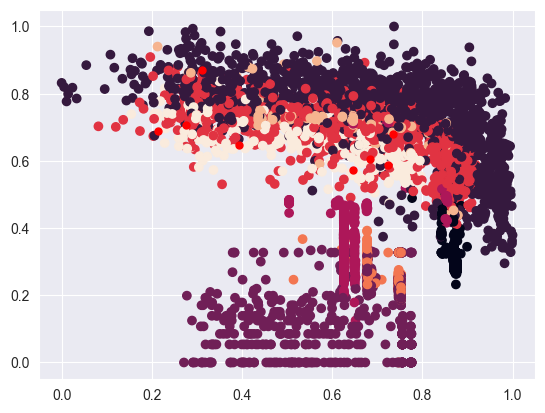

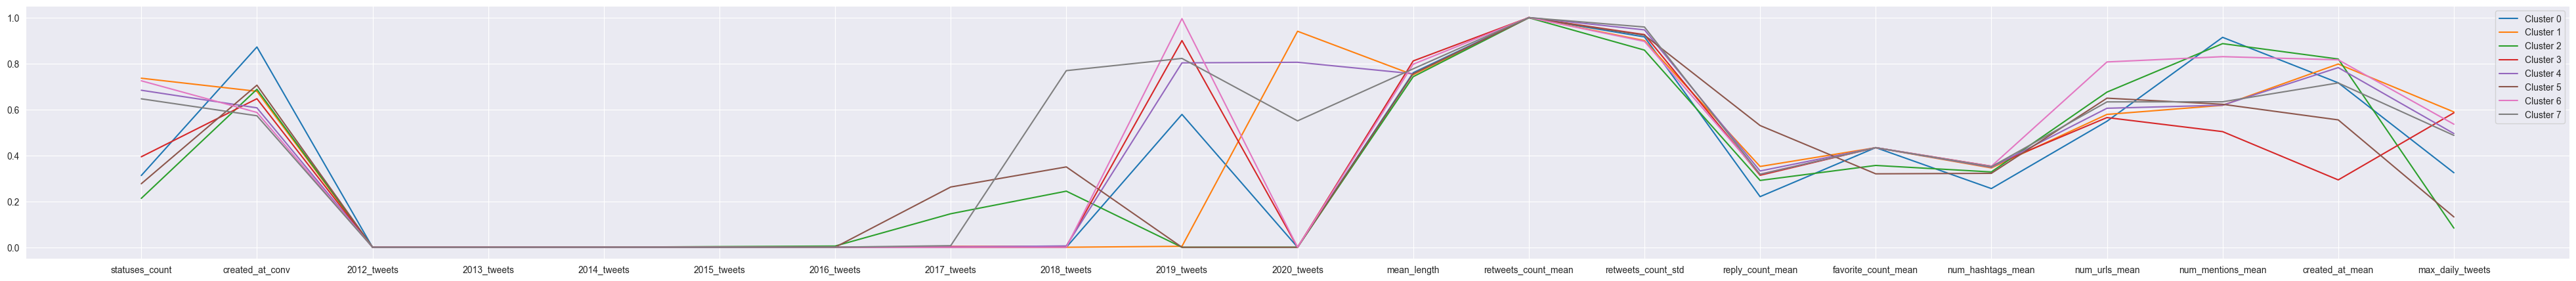

<Figure size 640x480 with 0 Axes>

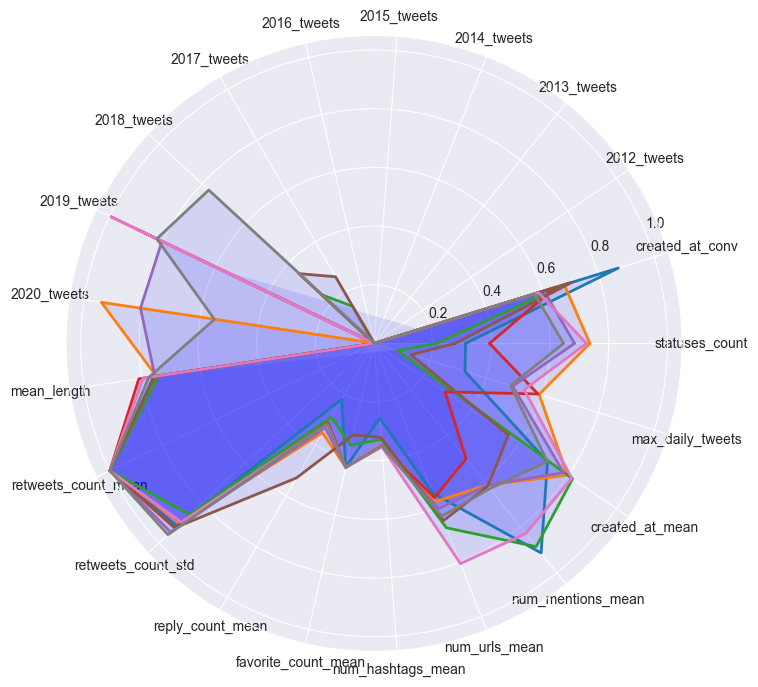

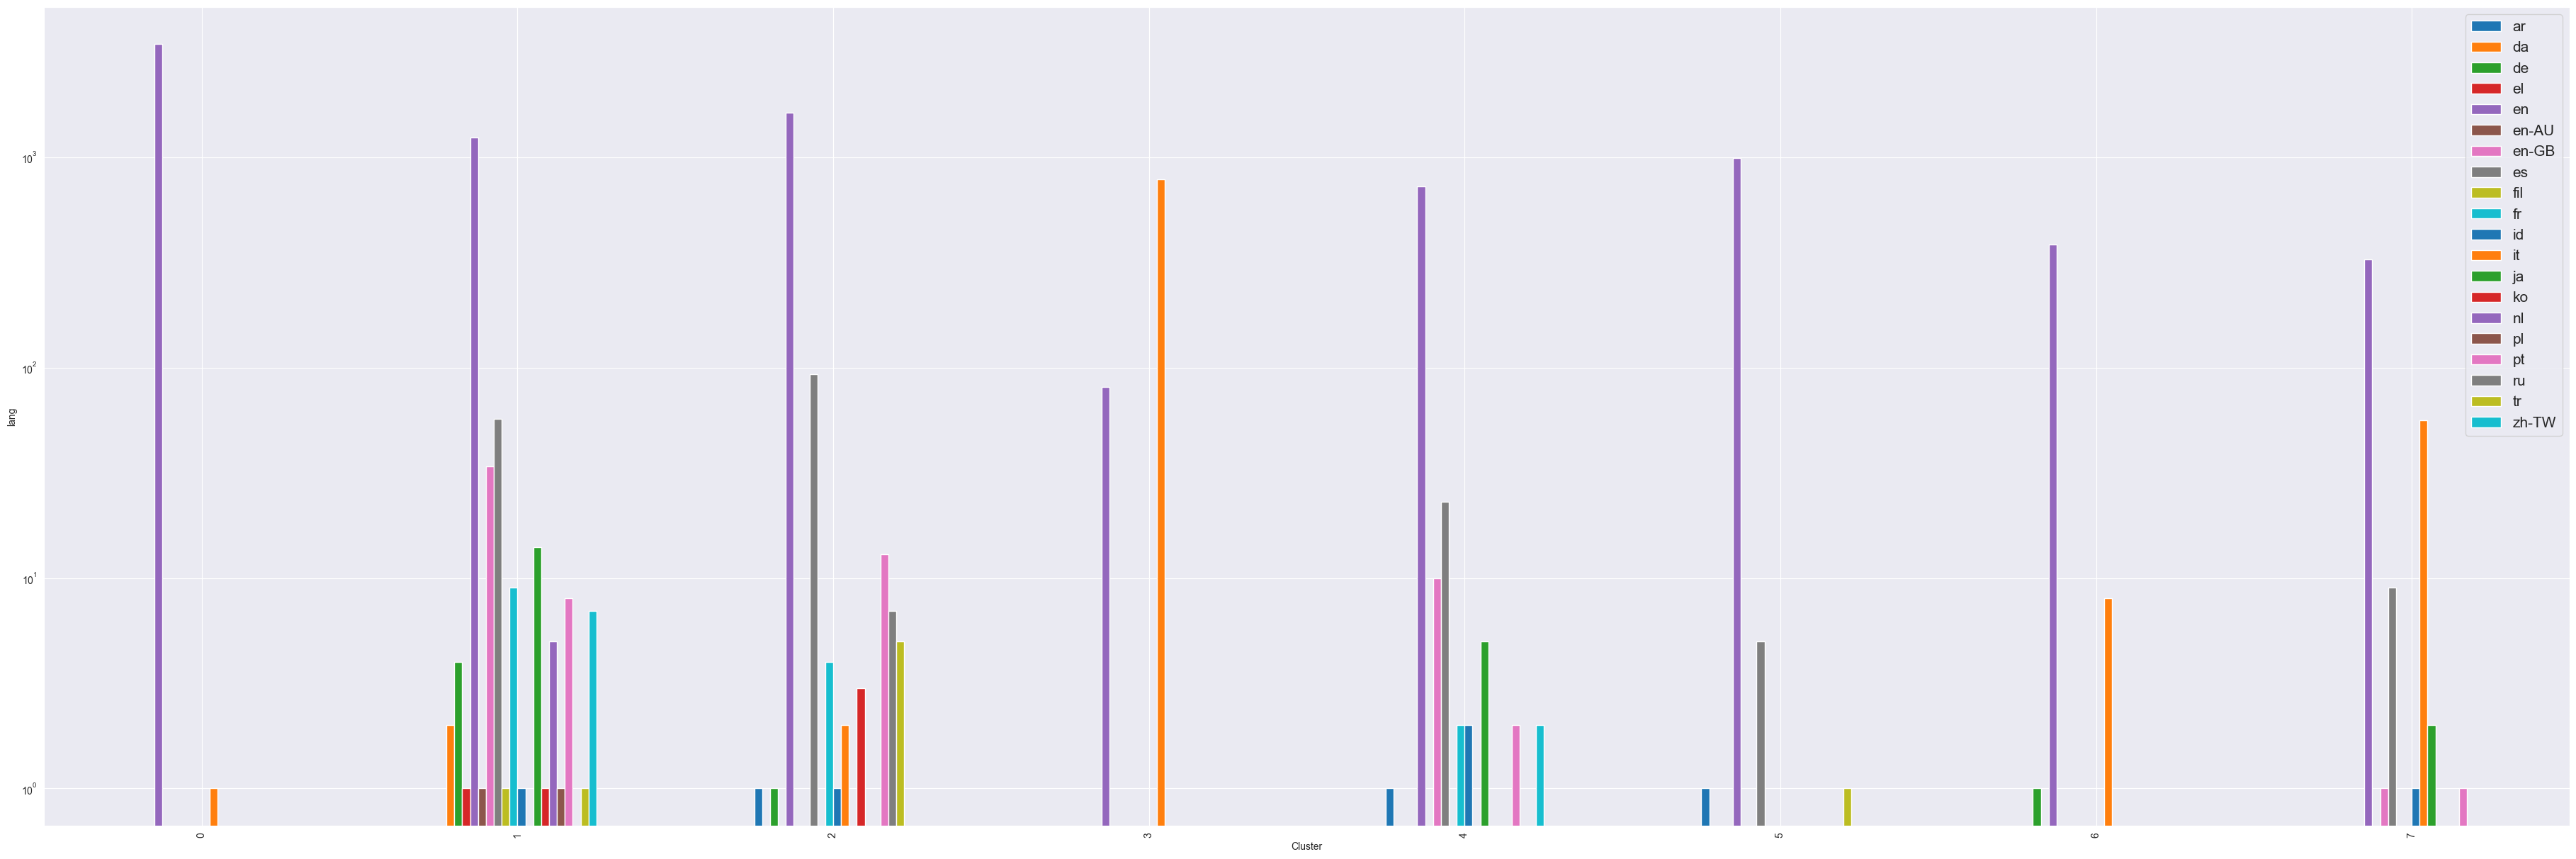

<Figure size 640x480 with 0 Axes>

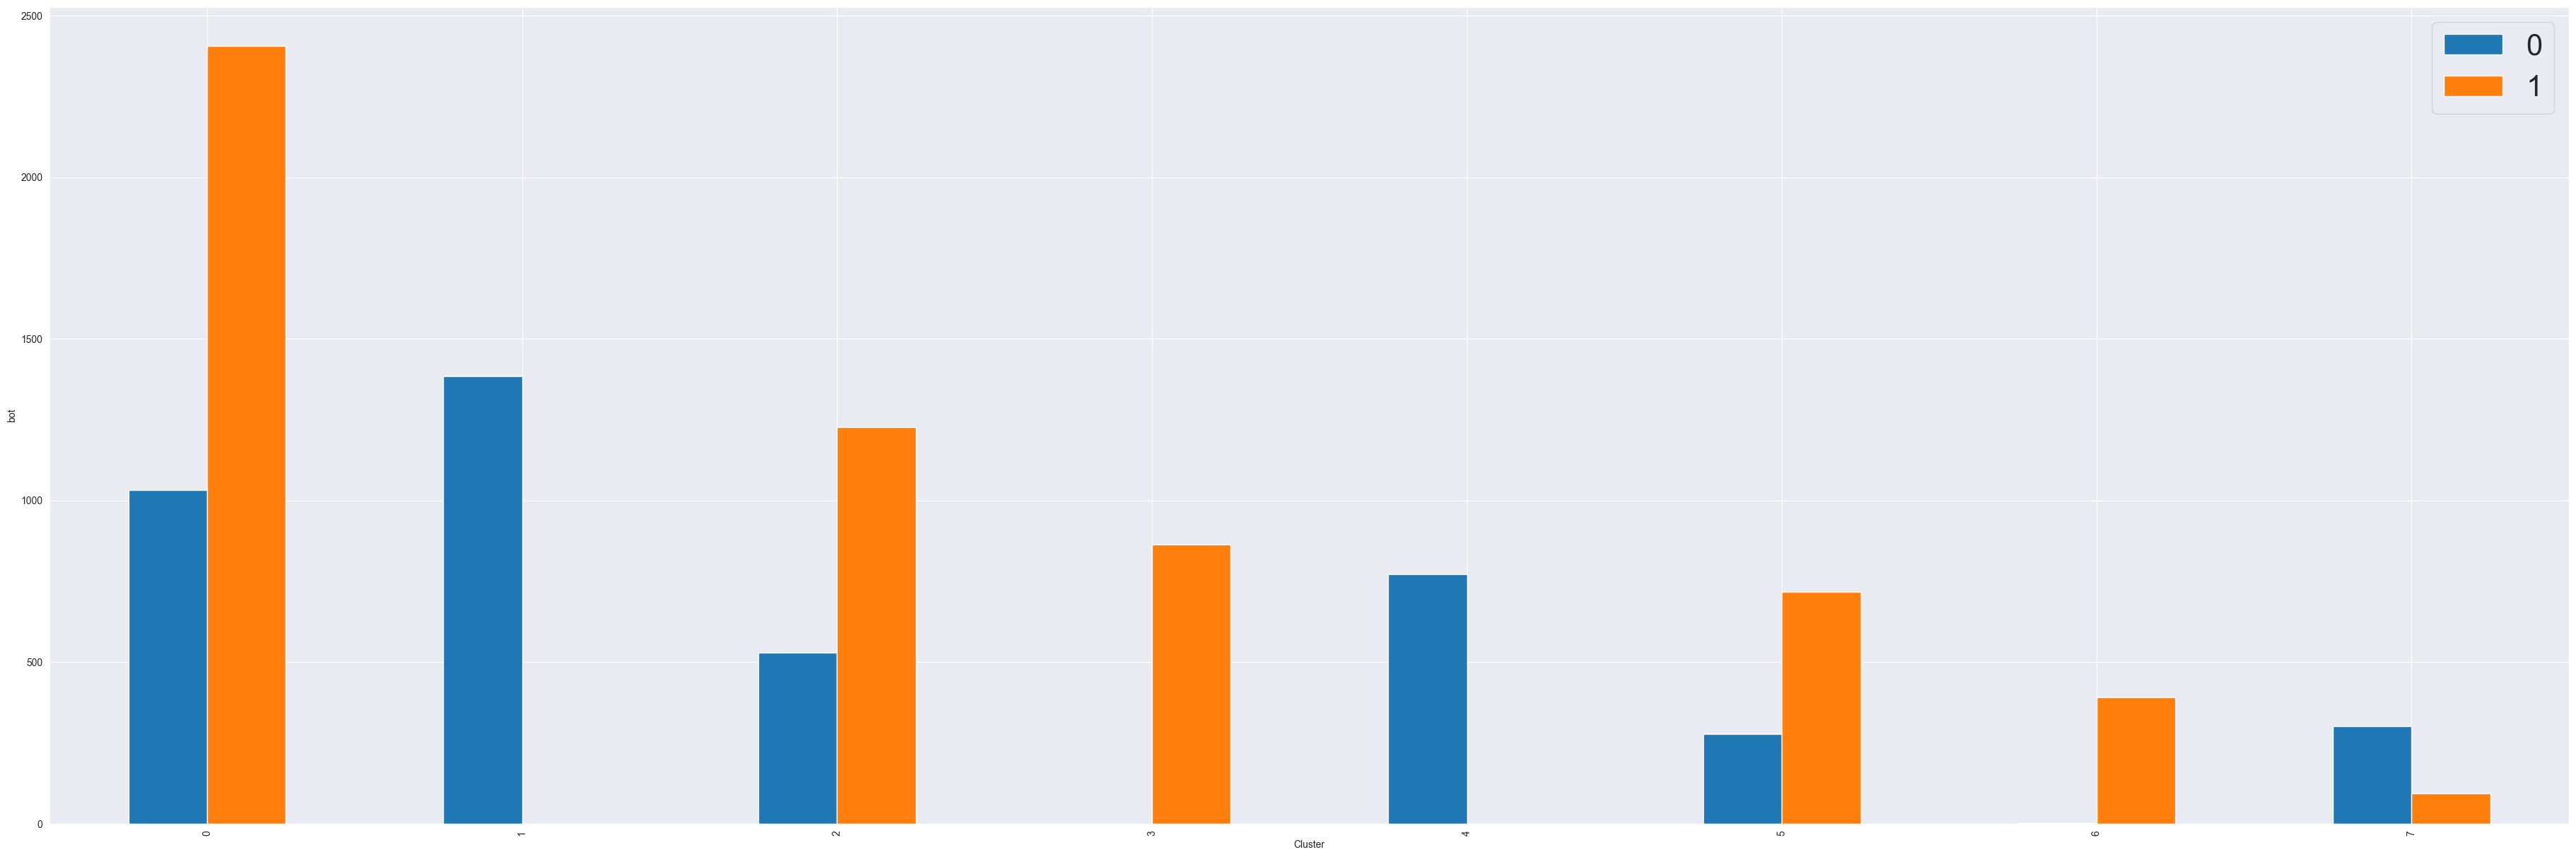

<Figure size 640x480 with 0 Axes>

In [46]:
kmeans_analysis(df_denoised, k=8, out_dir='kmeans/denoised_k8')

SSE: 878.7360759387989
Silouhette score: 0.5374736259354937
Davies Bouldin score: 0.8971197680196623


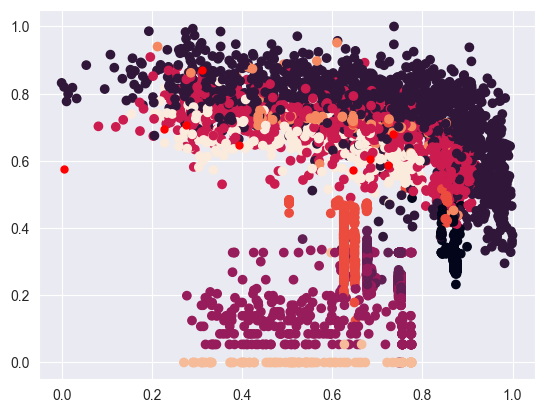

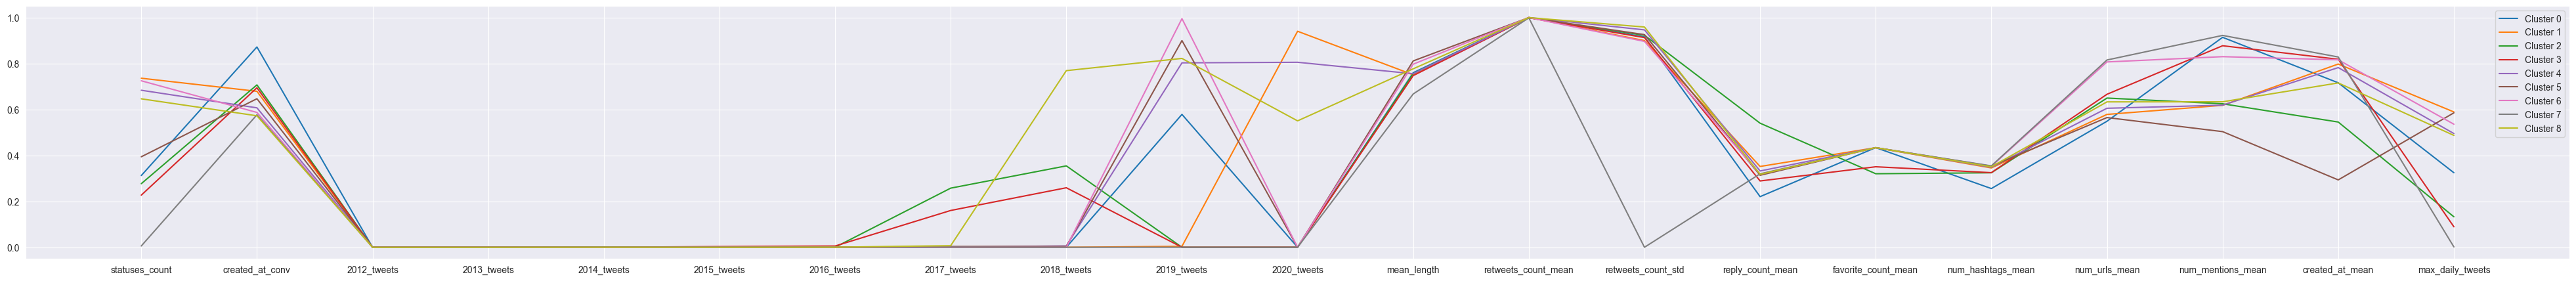

<Figure size 640x480 with 0 Axes>

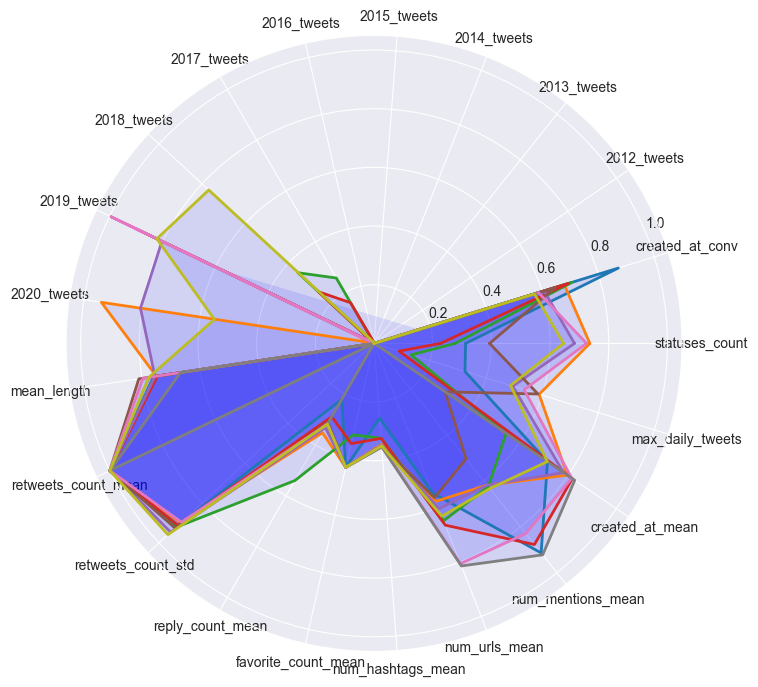

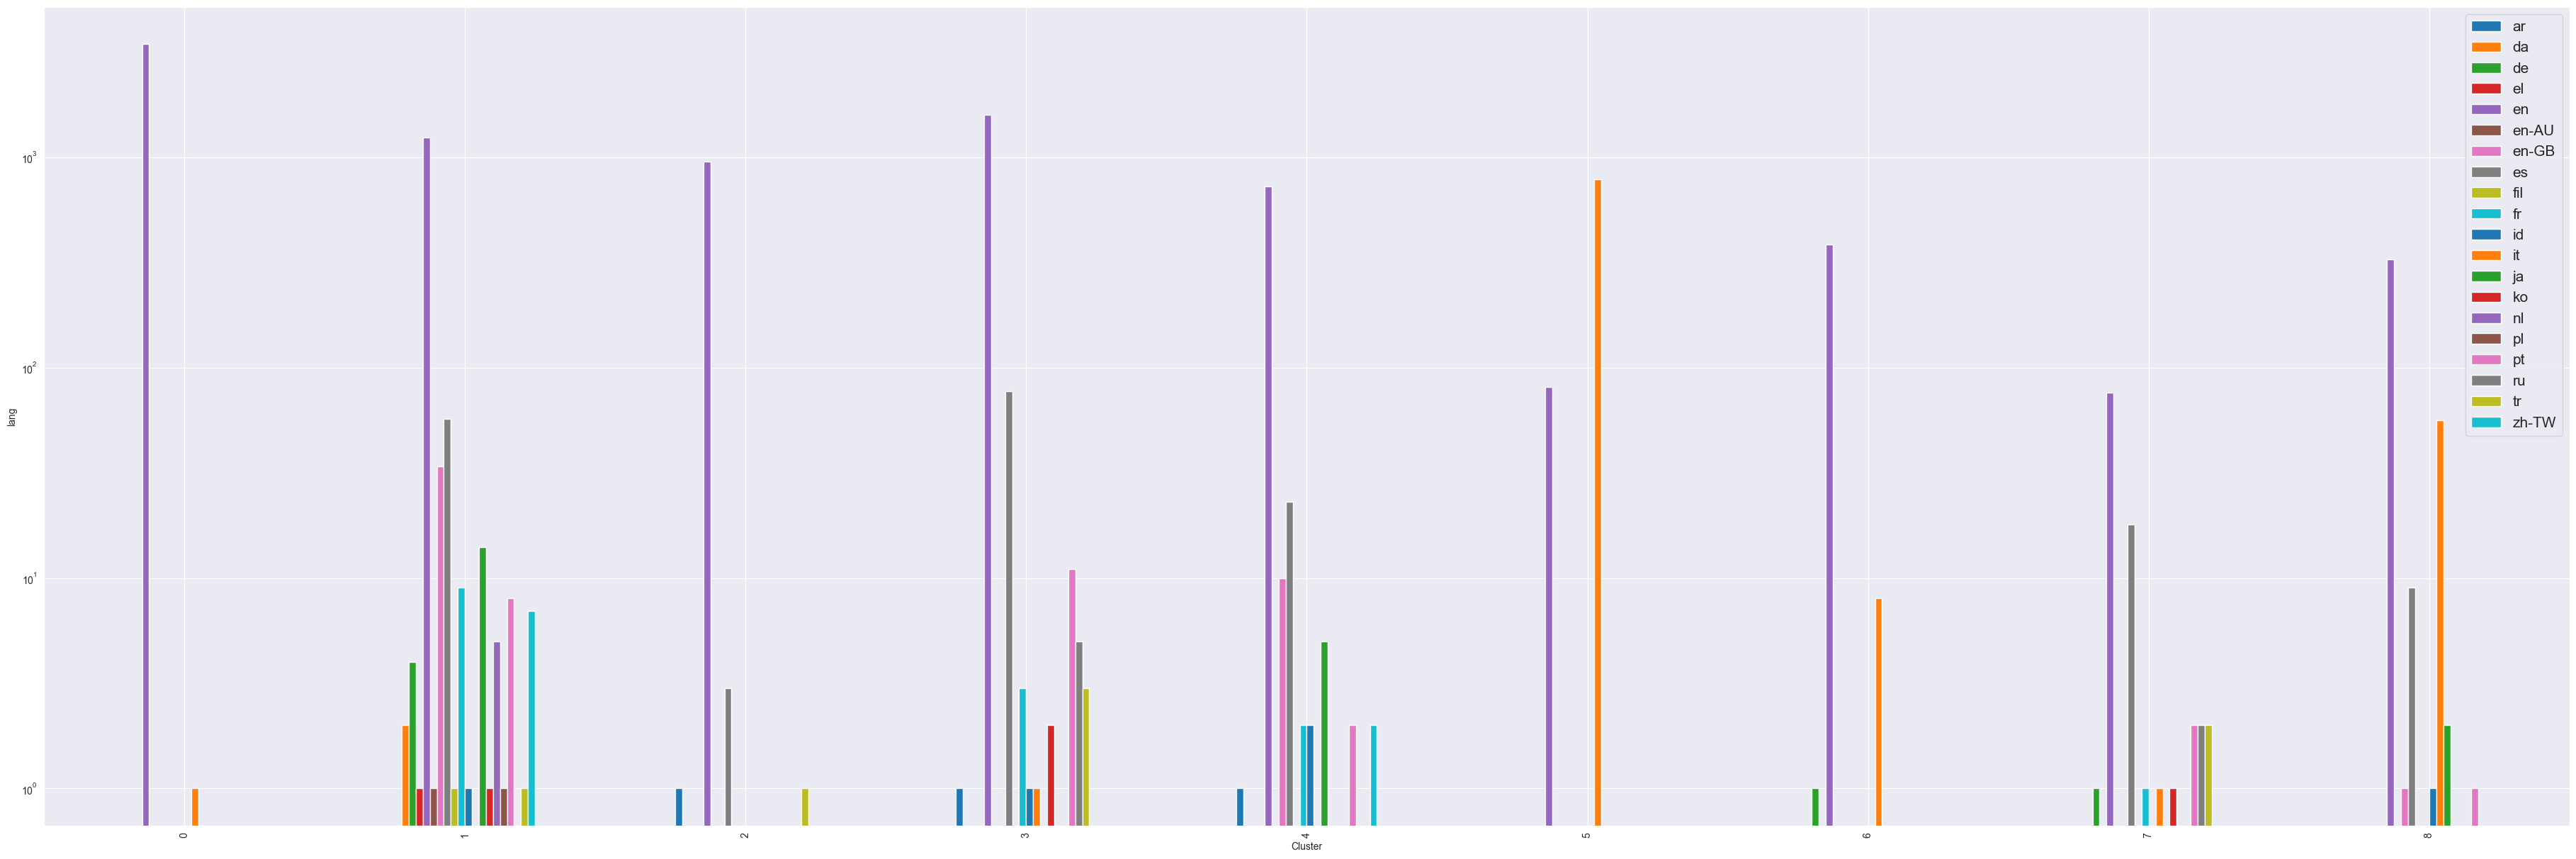

<Figure size 640x480 with 0 Axes>

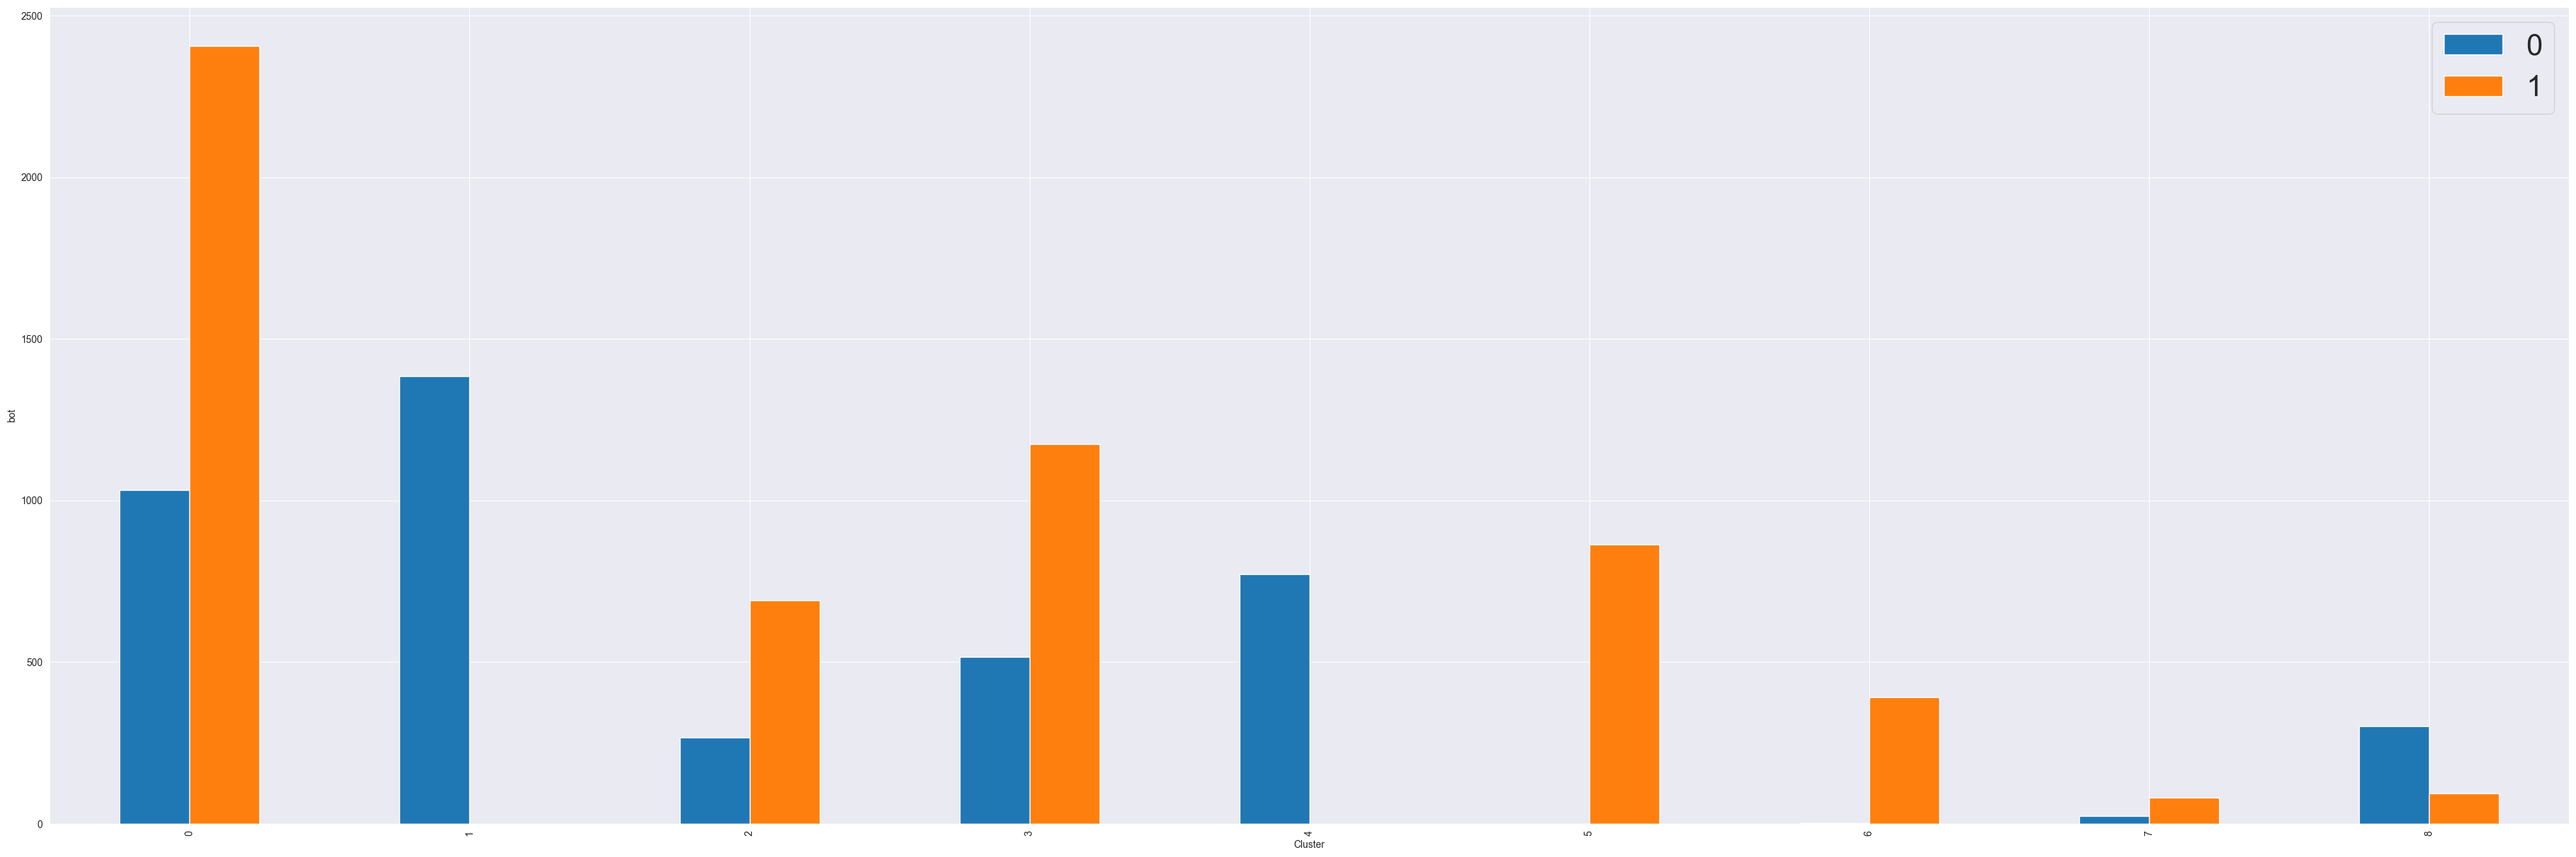

<Figure size 640x480 with 0 Axes>

In [47]:
kmeans_analysis(df_denoised, k=9, out_dir='kmeans/denoised_k9')

SSE: 802.8612824965322
Silouhette score: 0.5343785549798334
Davies Bouldin score: 0.8844650017949458


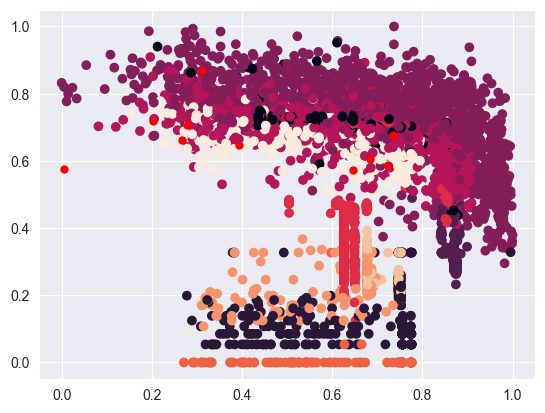

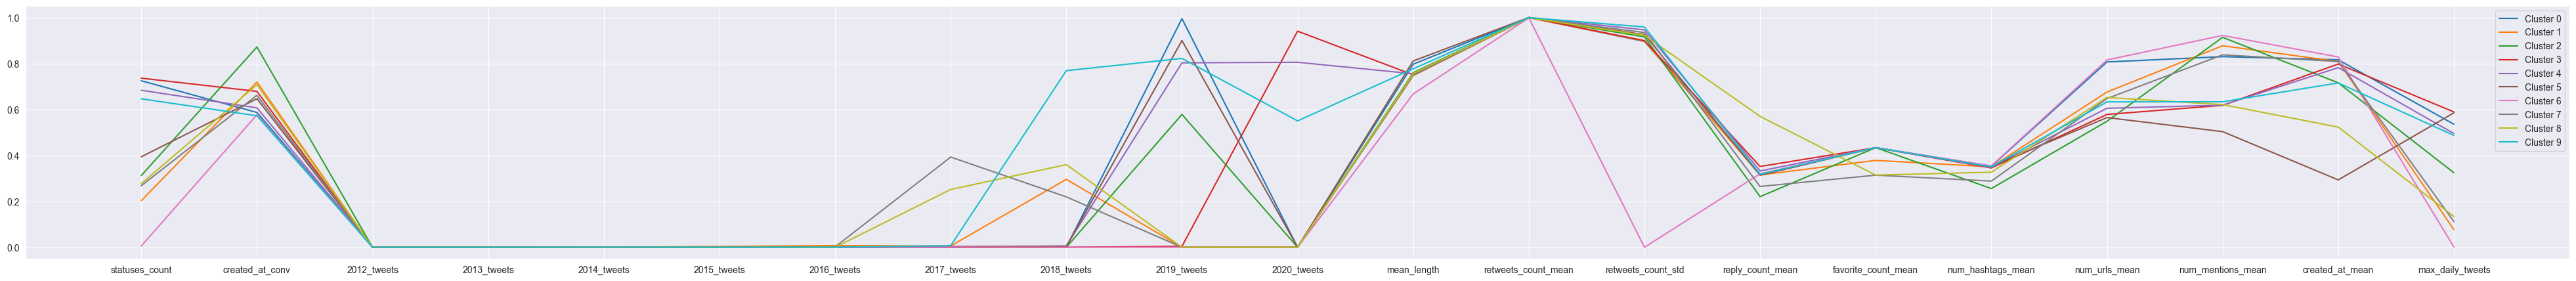

<Figure size 640x480 with 0 Axes>

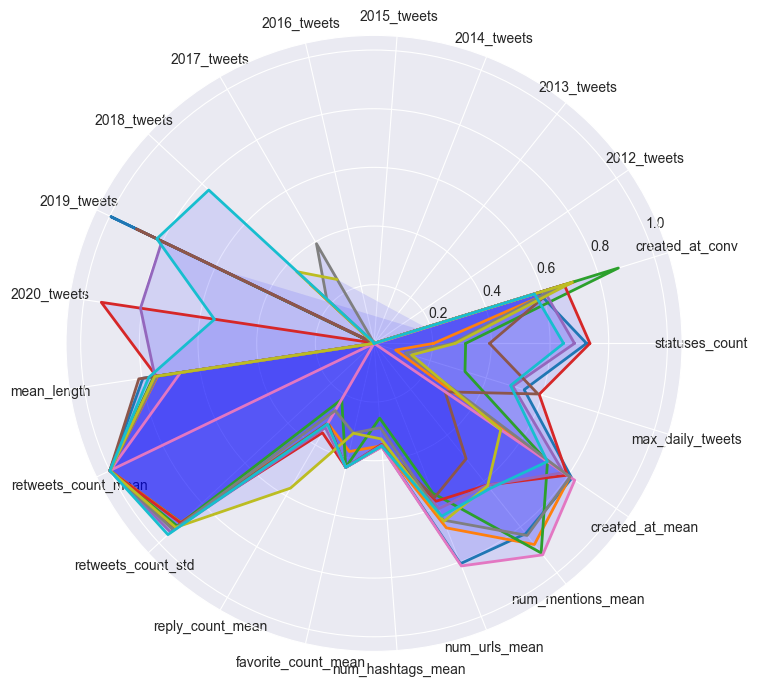

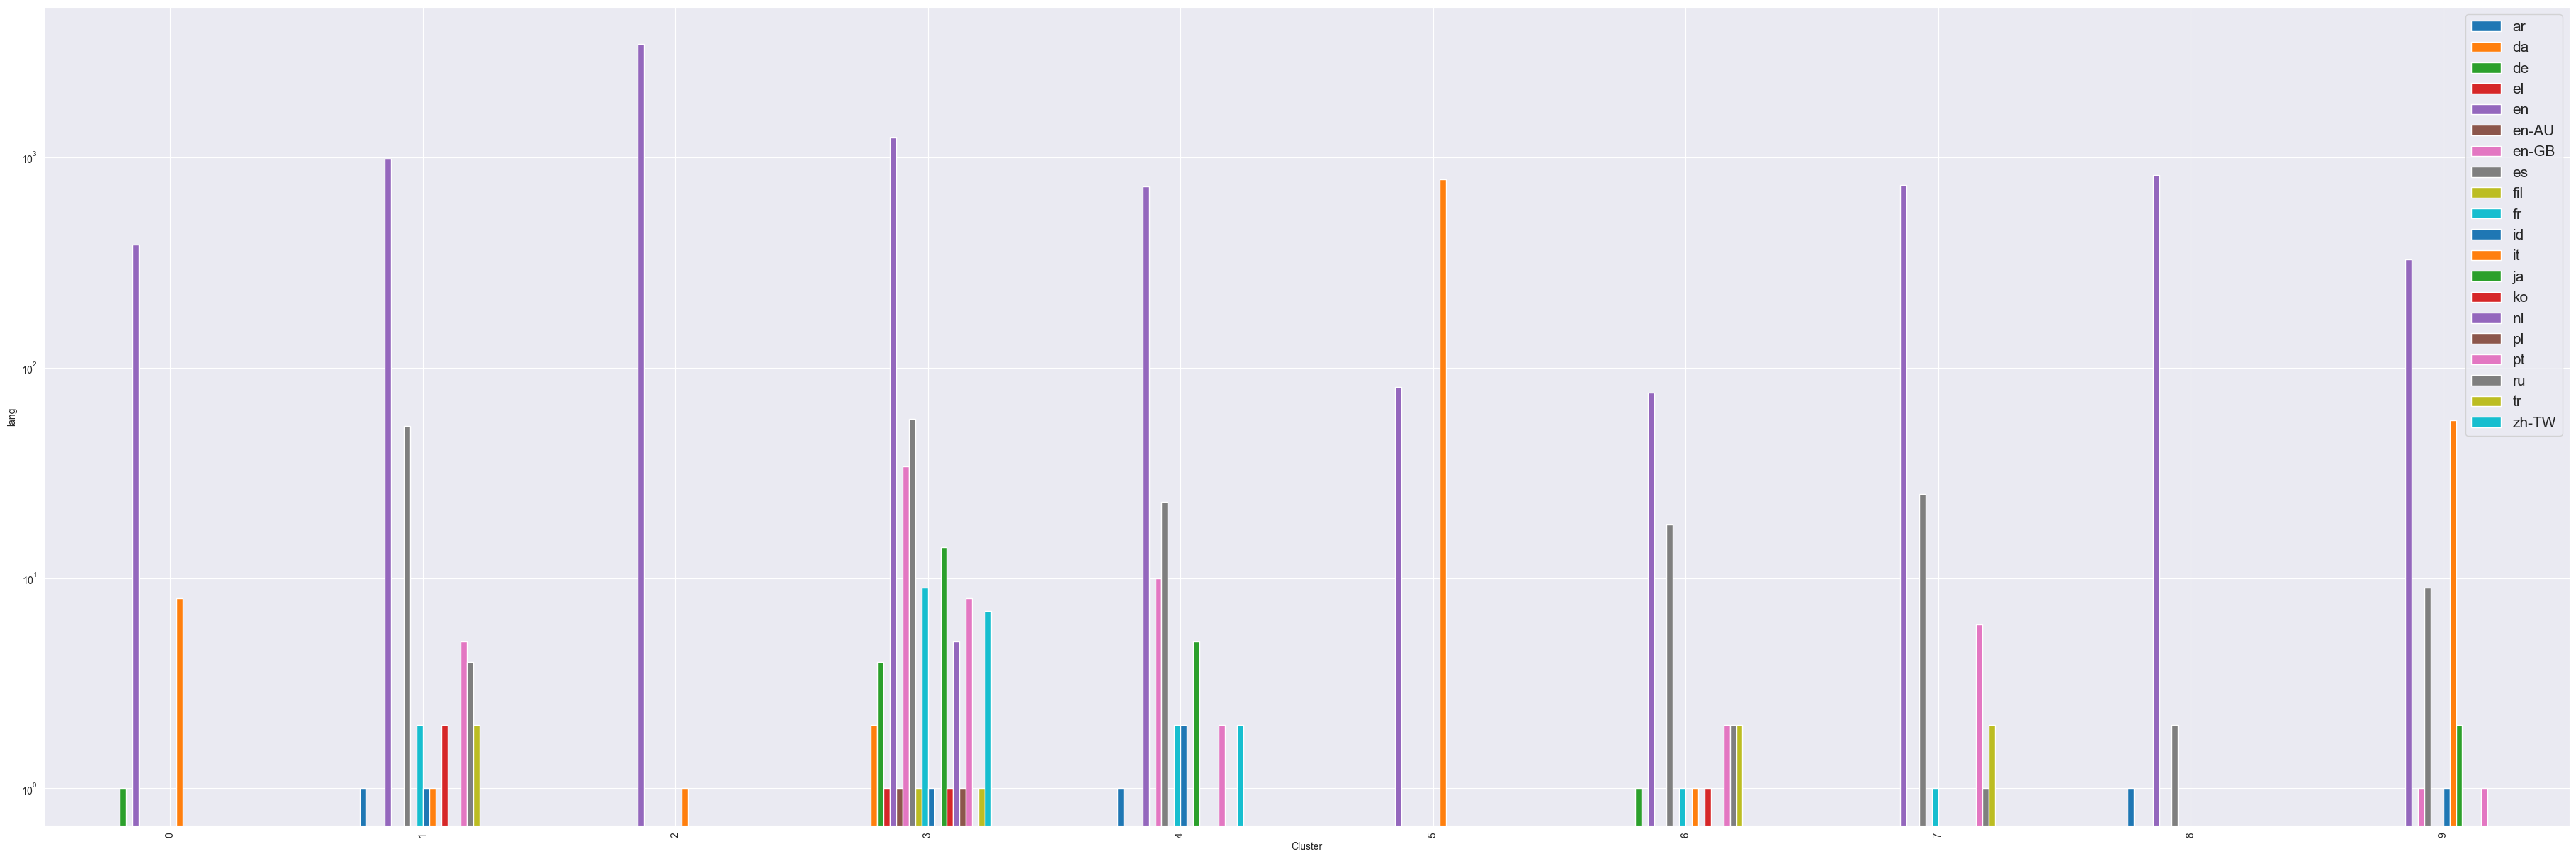

<Figure size 640x480 with 0 Axes>

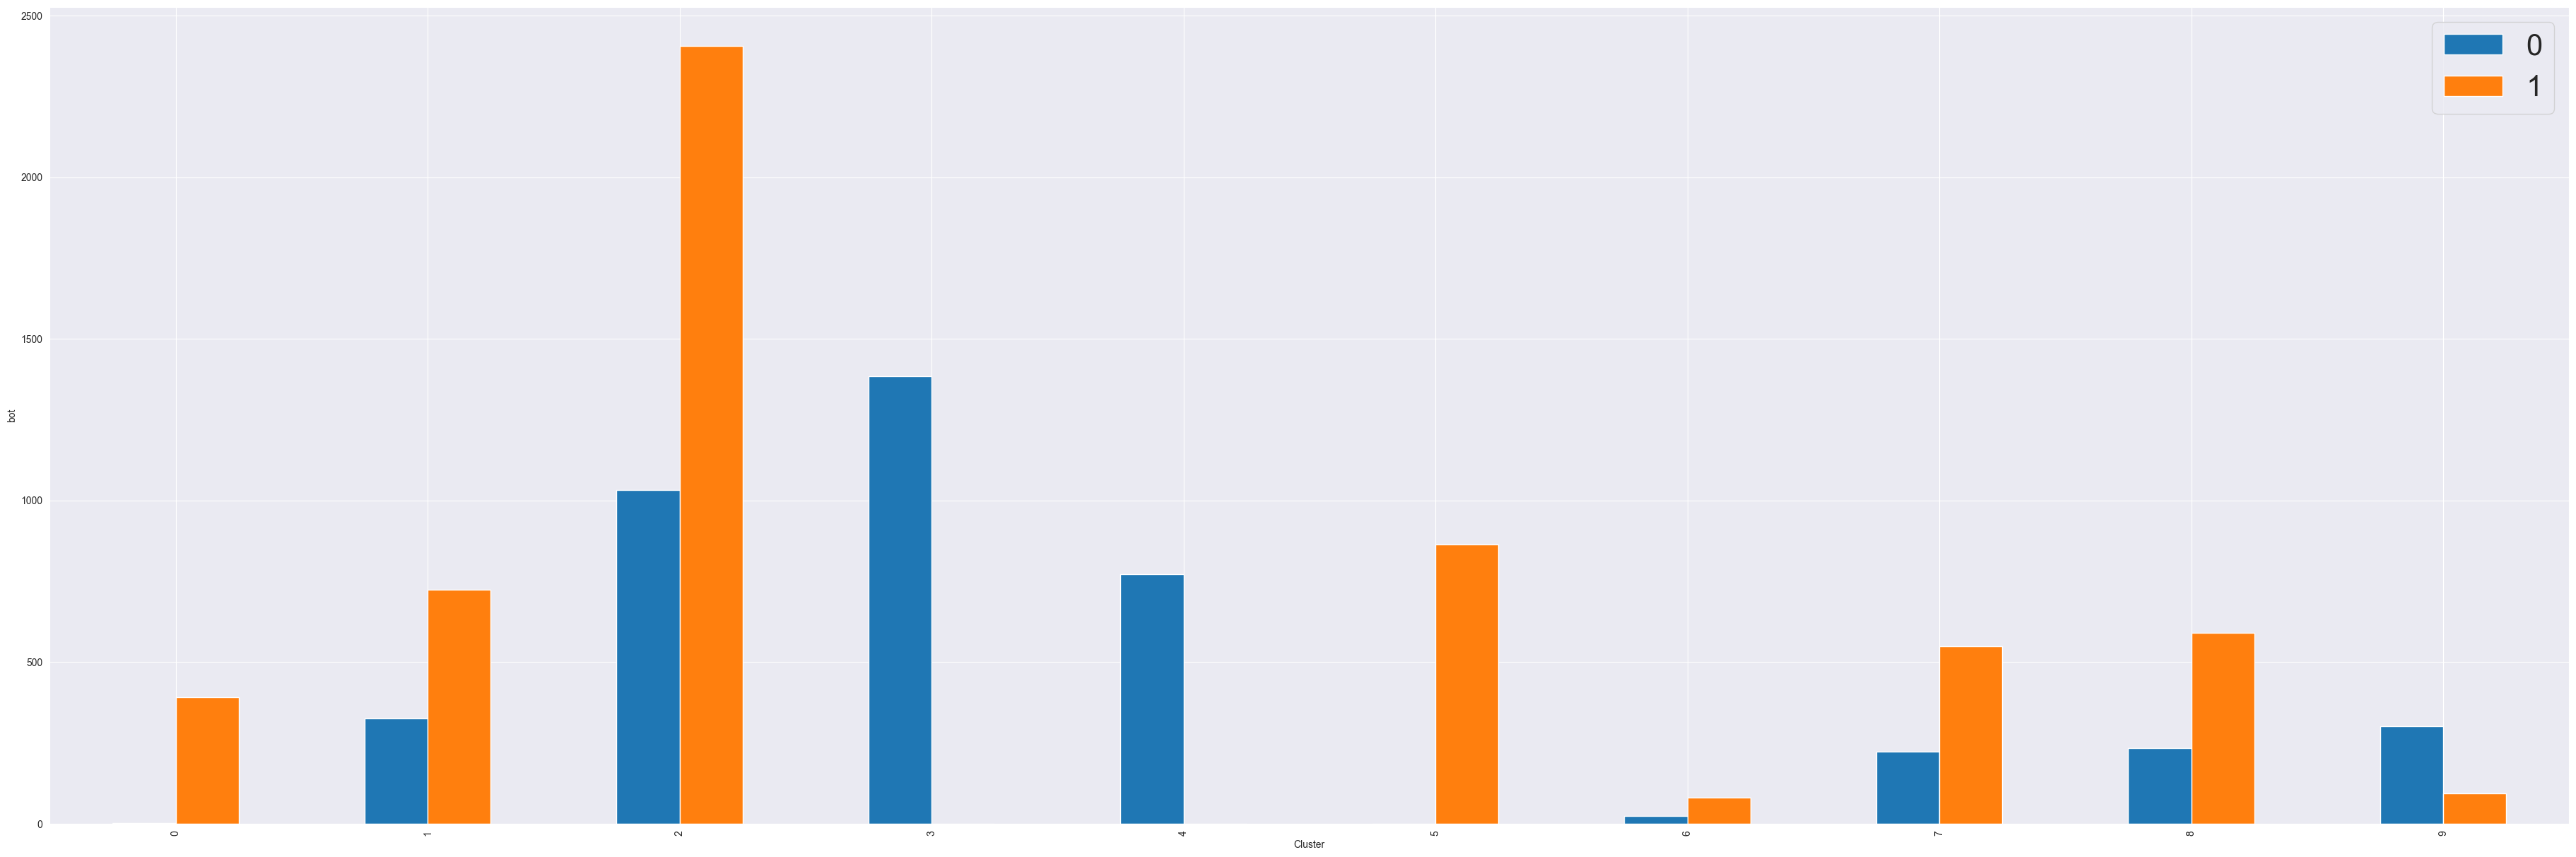

<Figure size 640x480 with 0 Axes>

In [48]:
kmeans_analysis(df_denoised, k=10, out_dir='kmeans/denoised_k10')

# Hierarchical clustering

In [49]:
try:
  os.mkdir('hierarchical')
except:
  pass

This approach is tested on both noisy and denoised data.

In [50]:
metric = 'euclidean'
distances = pdist(df_merge_scaled[numeric_attributes], metric=metric)

In [51]:
dlinkage = linkage(distances, metric=metric, method='complete')

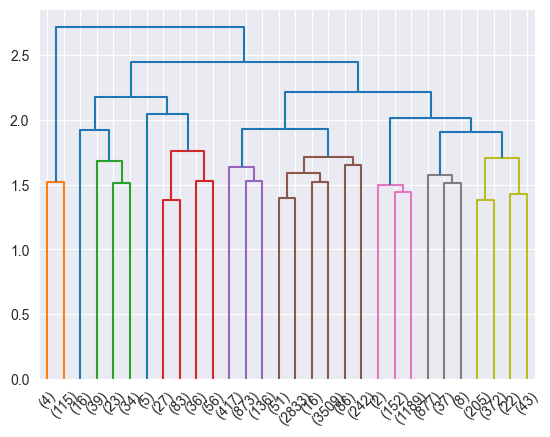

In [52]:
res = dendrogram(dlinkage, truncate_mode='lastp')

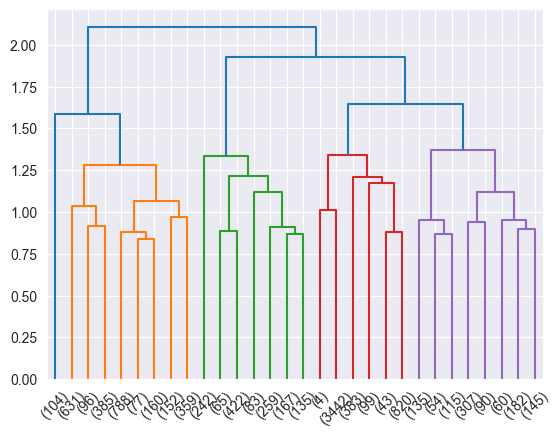

In [53]:
metric = 'euclidean'
distances = pdist(df_denoised[numeric_attributes], metric=metric)
dlinkage = linkage(distances, metric=metric, method='complete')
res = dendrogram(dlinkage, truncate_mode='lastp')

In [54]:
clusters = AgglomerativeClustering(affinity='euclidean', n_clusters=6, linkage='ward')
clusters.fit(df_merge_scaled[numeric_attributes])

AgglomerativeClustering(n_clusters=6)

In [55]:
get_metrics(df_merge_scaled[numeric_attributes], clusters.labels_)

Silouhette score: 0.42320501329769156
Davies Bouldin score: 1.0700477015855132


In [56]:
type(clusters.labels_)

numpy.ndarray

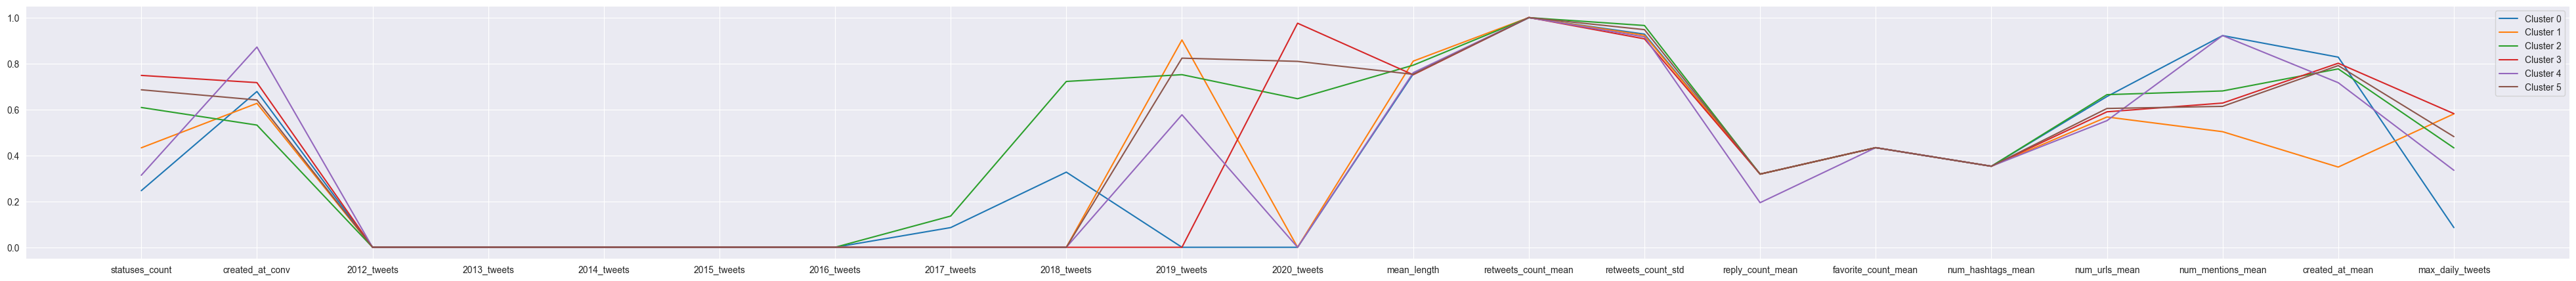

<Figure size 640x480 with 0 Axes>

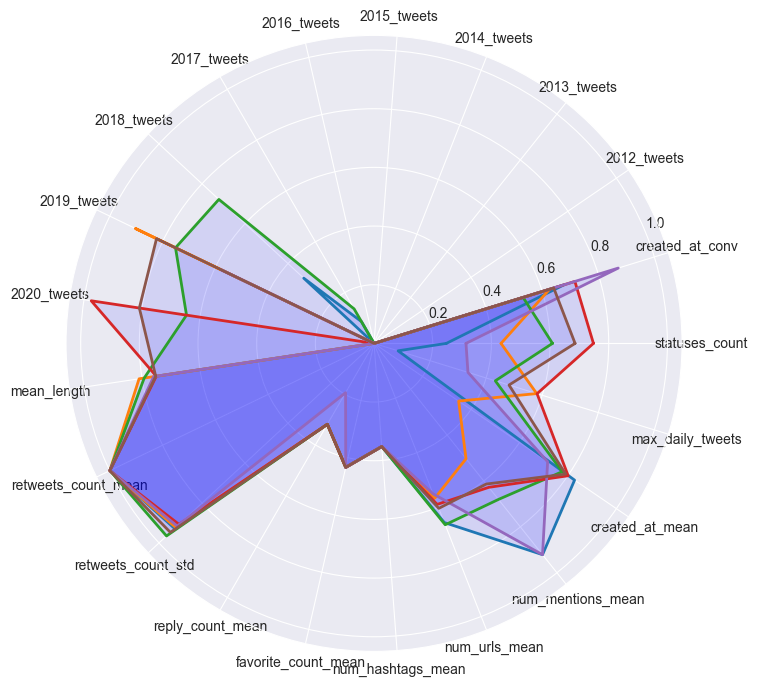

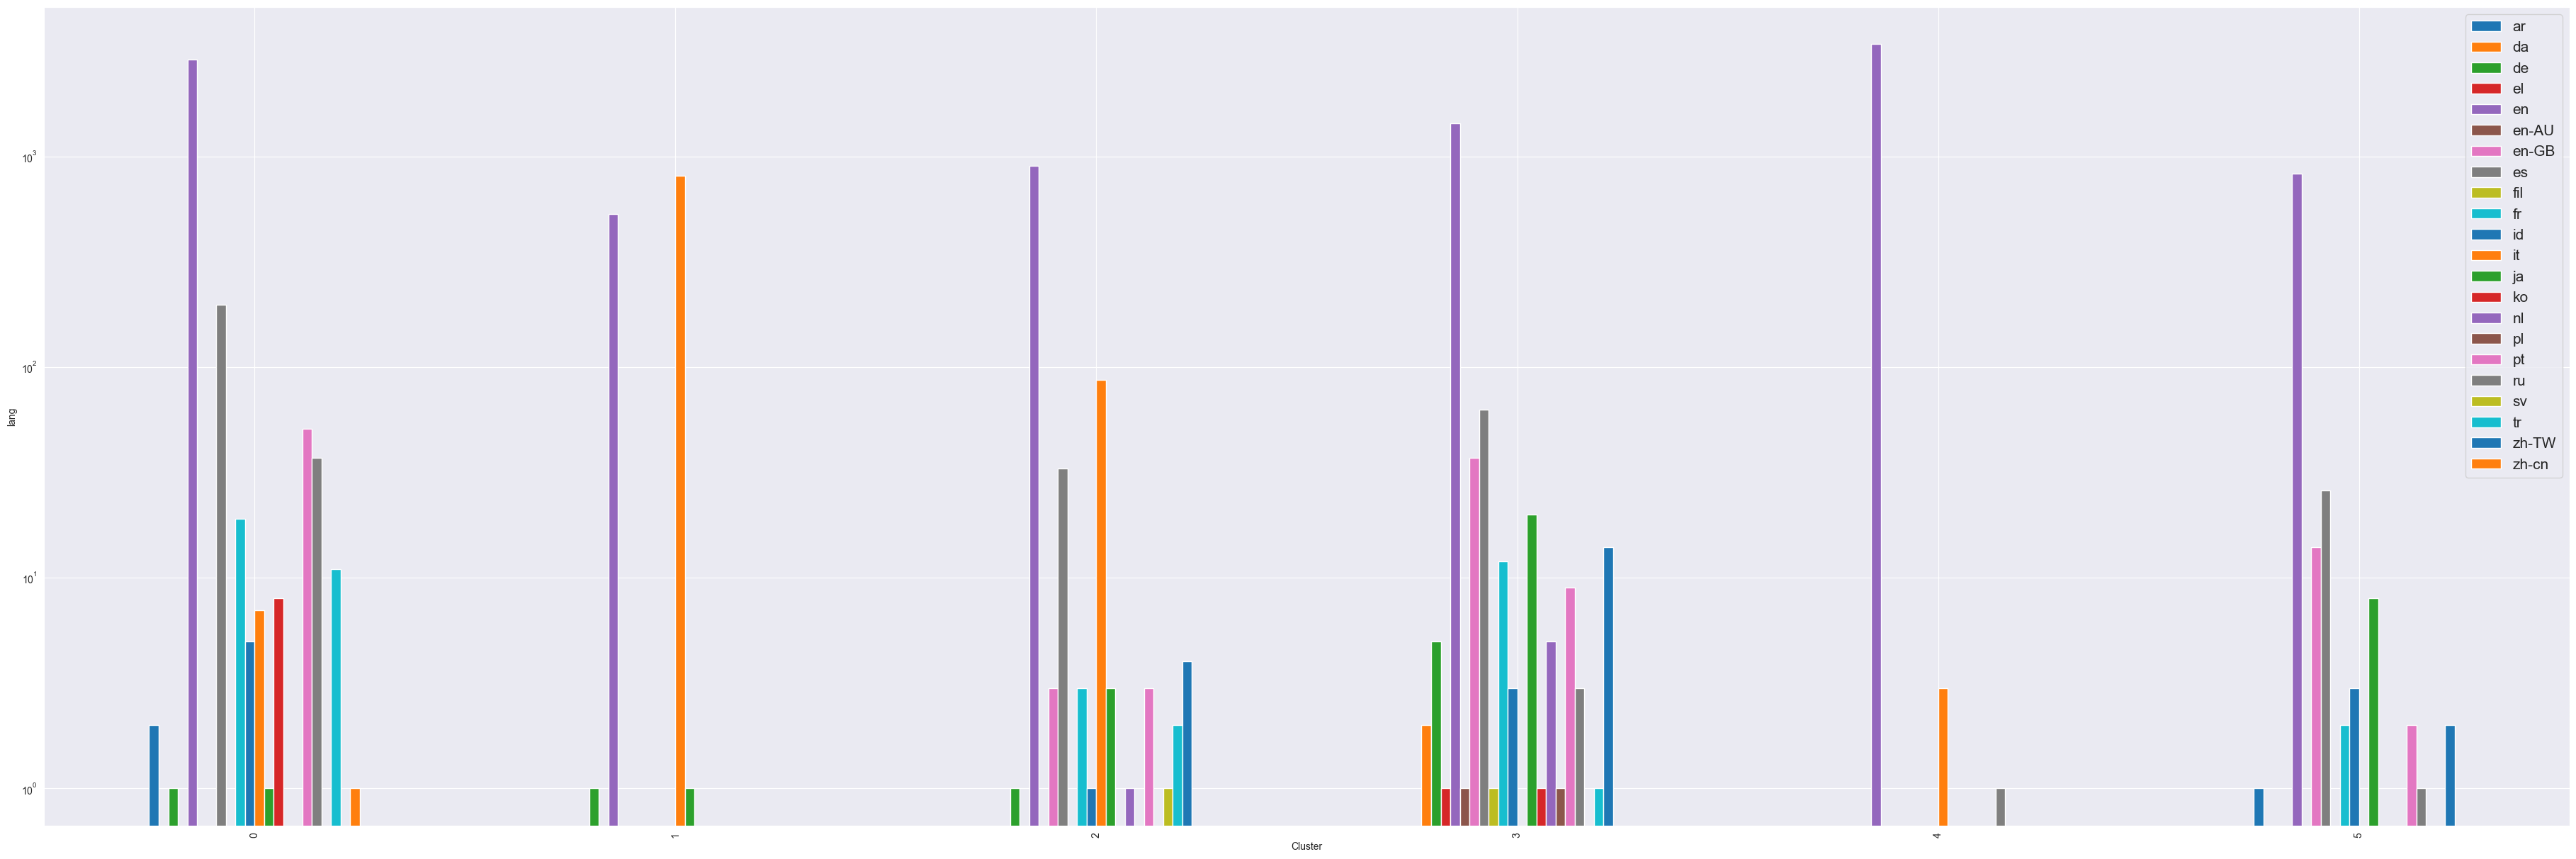

<Figure size 640x480 with 0 Axes>

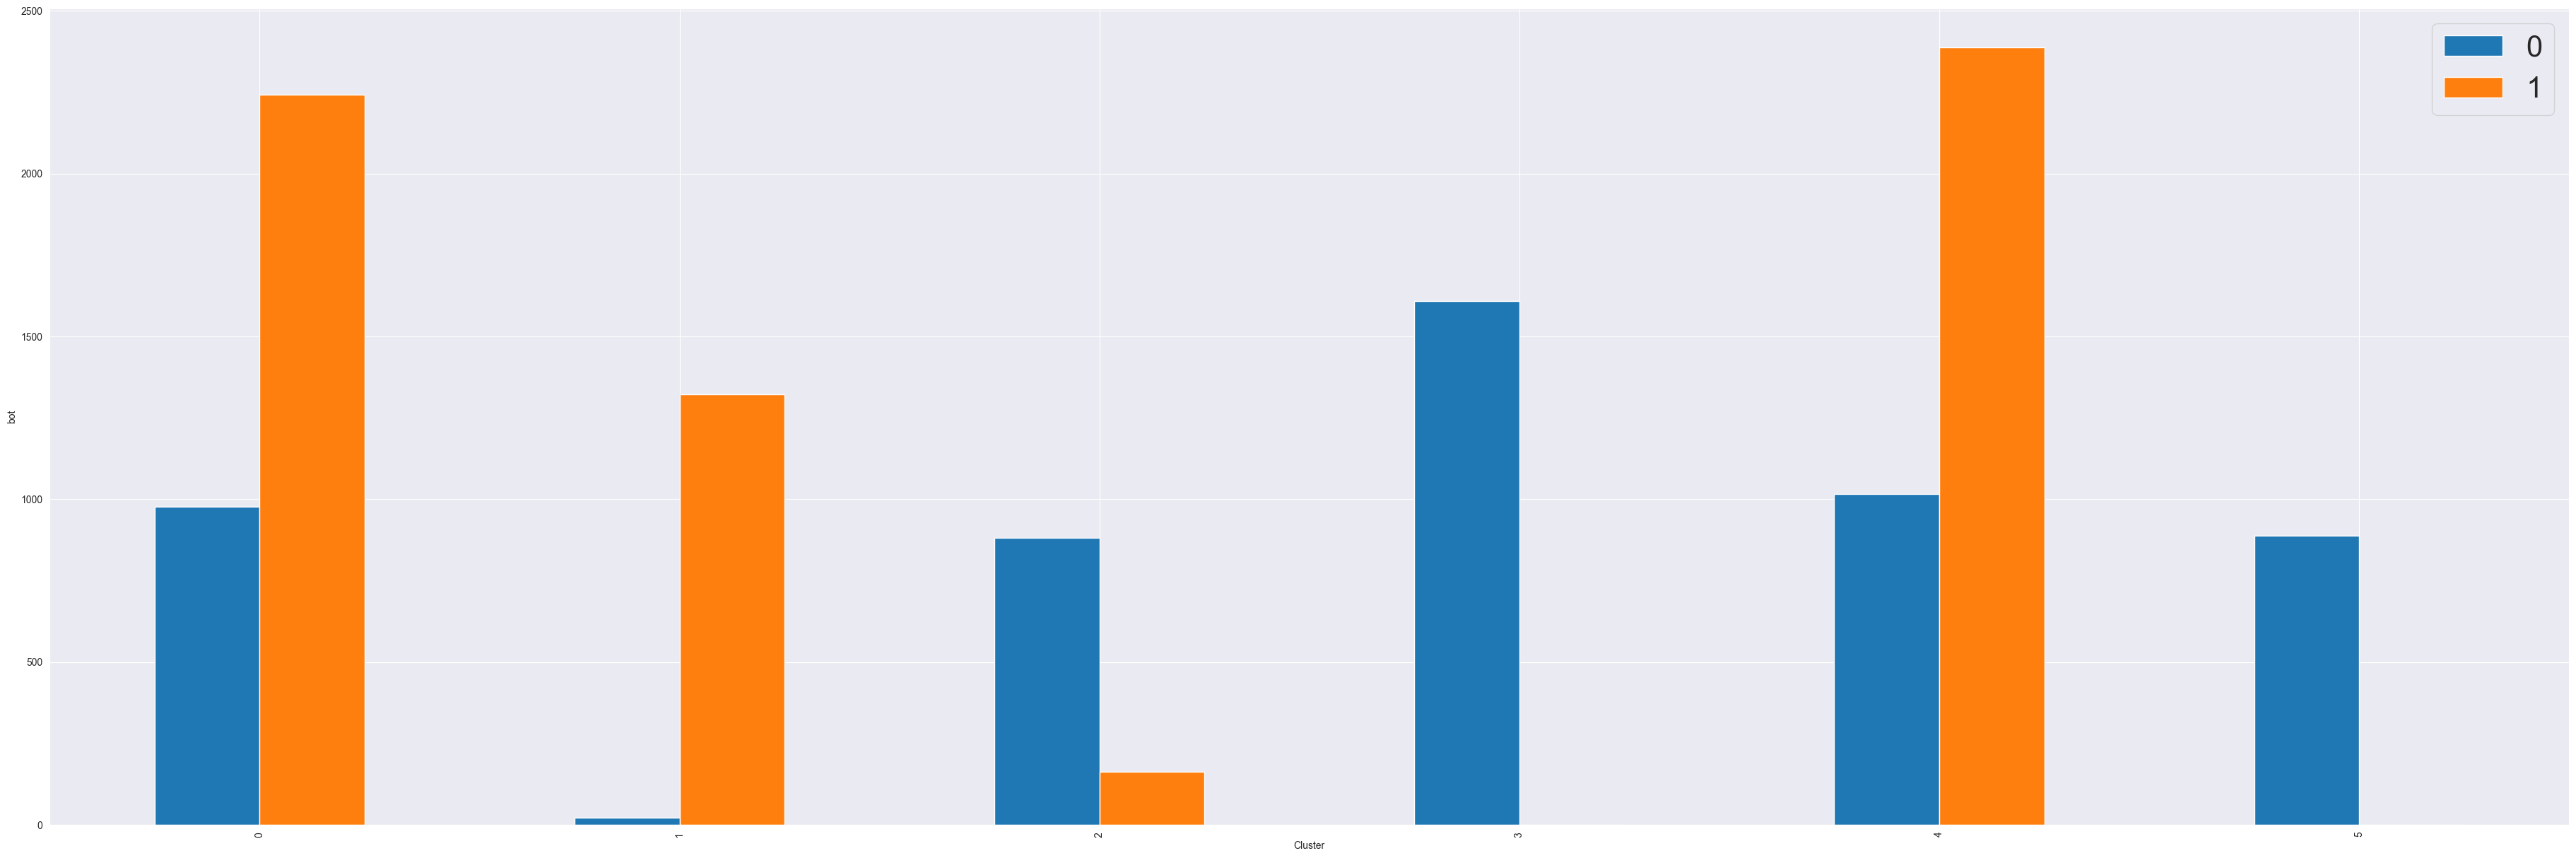

<Figure size 640x480 with 0 Axes>

In [57]:
plots(df_merge_scaled, clusters.labels_, path='hierarchical', attributes=numeric_attributes)

# X-Means

from https://github.com/annoviko/pyclustering/

In [58]:
try:
  os.mkdir('xmeans')
except:
  pass

In [59]:

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

k_start = 2
clusters_start = kmeans_plusplus_initializer(df_merge_scaled[numeric_attributes], 2).initialize()
 
# By defeault max # of clusters is 20, but we set it to 40
x_means = xmeans(df_merge_scaled[numeric_attributes], clusters_start, kmax=10, repeat=300) #, initial_centers, 20)
x_means.process()
 
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centroids = x_means.get_centers()

print(f'Number of clusters found:', np.shape(centroids)[0])

Number of clusters found: 10


In [60]:
cluster_labels = dict()

''' 
Since for each cluster is saved the index in list of data
it is needed to convert it in such a way that
we have a list as long as the data, and in each
position it is saved the corresponding label for the
data with that index
'''
for label in range(0, np.shape(clusters)[0]):
  for i in range(0, len(clusters[label])):
    cluster_labels[clusters[label][i]] = label

cluster_labels = dict(sorted(cluster_labels.items()))

C:\Users\Alessandro\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [61]:
print("SSE:", x_means.get_total_wce())
get_metrics(df_merge_scaled[numeric_attributes], list(cluster_labels.values()))

SSE: 1767.7199882903474
Silouhette score: 0.33063519365635535
Davies Bouldin score: 1.1124516959547244


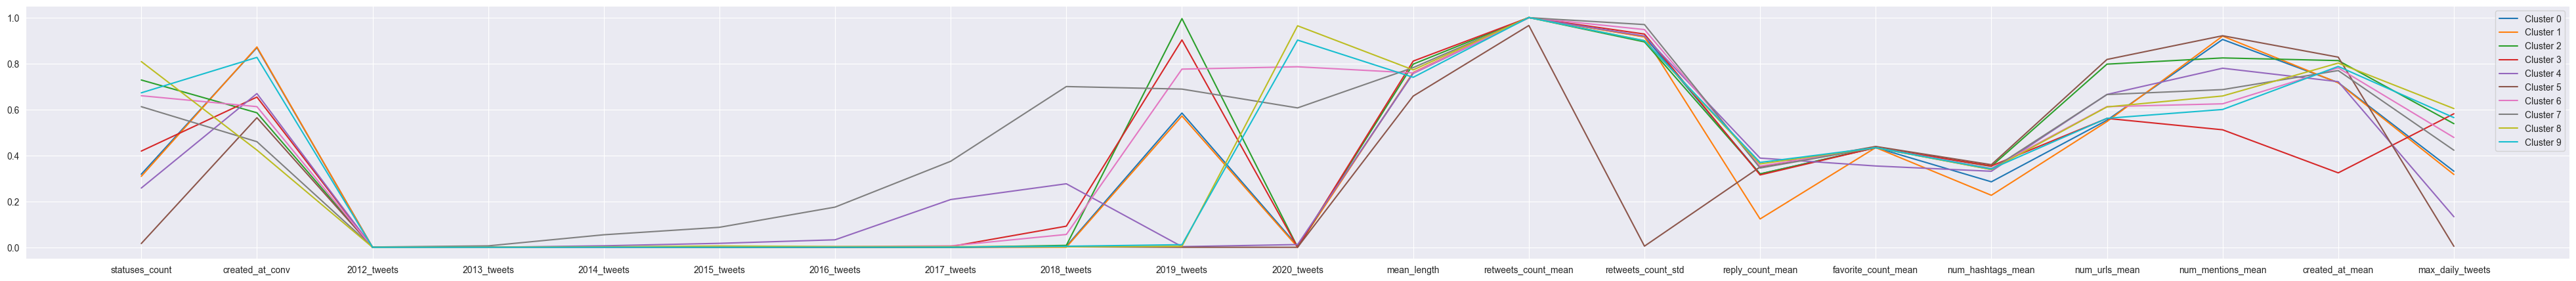

<Figure size 640x480 with 0 Axes>

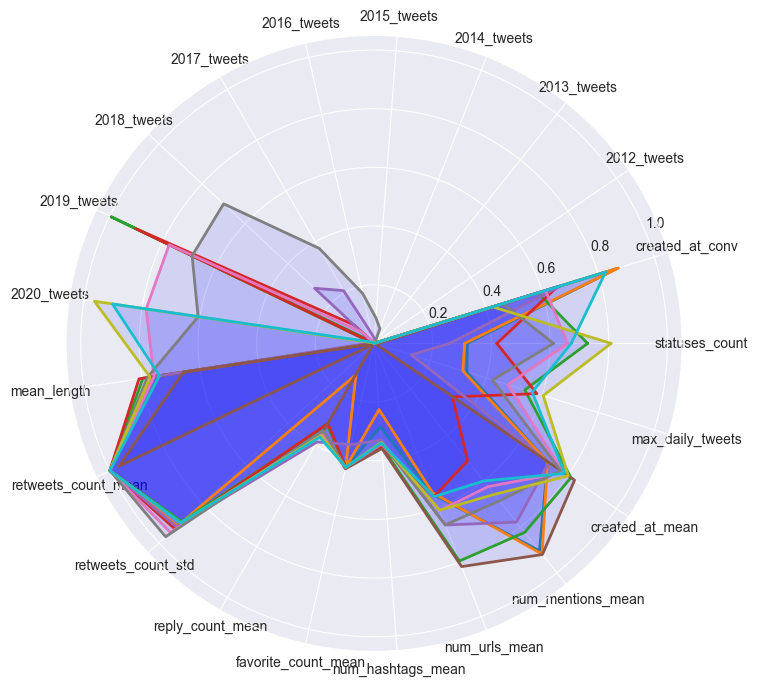

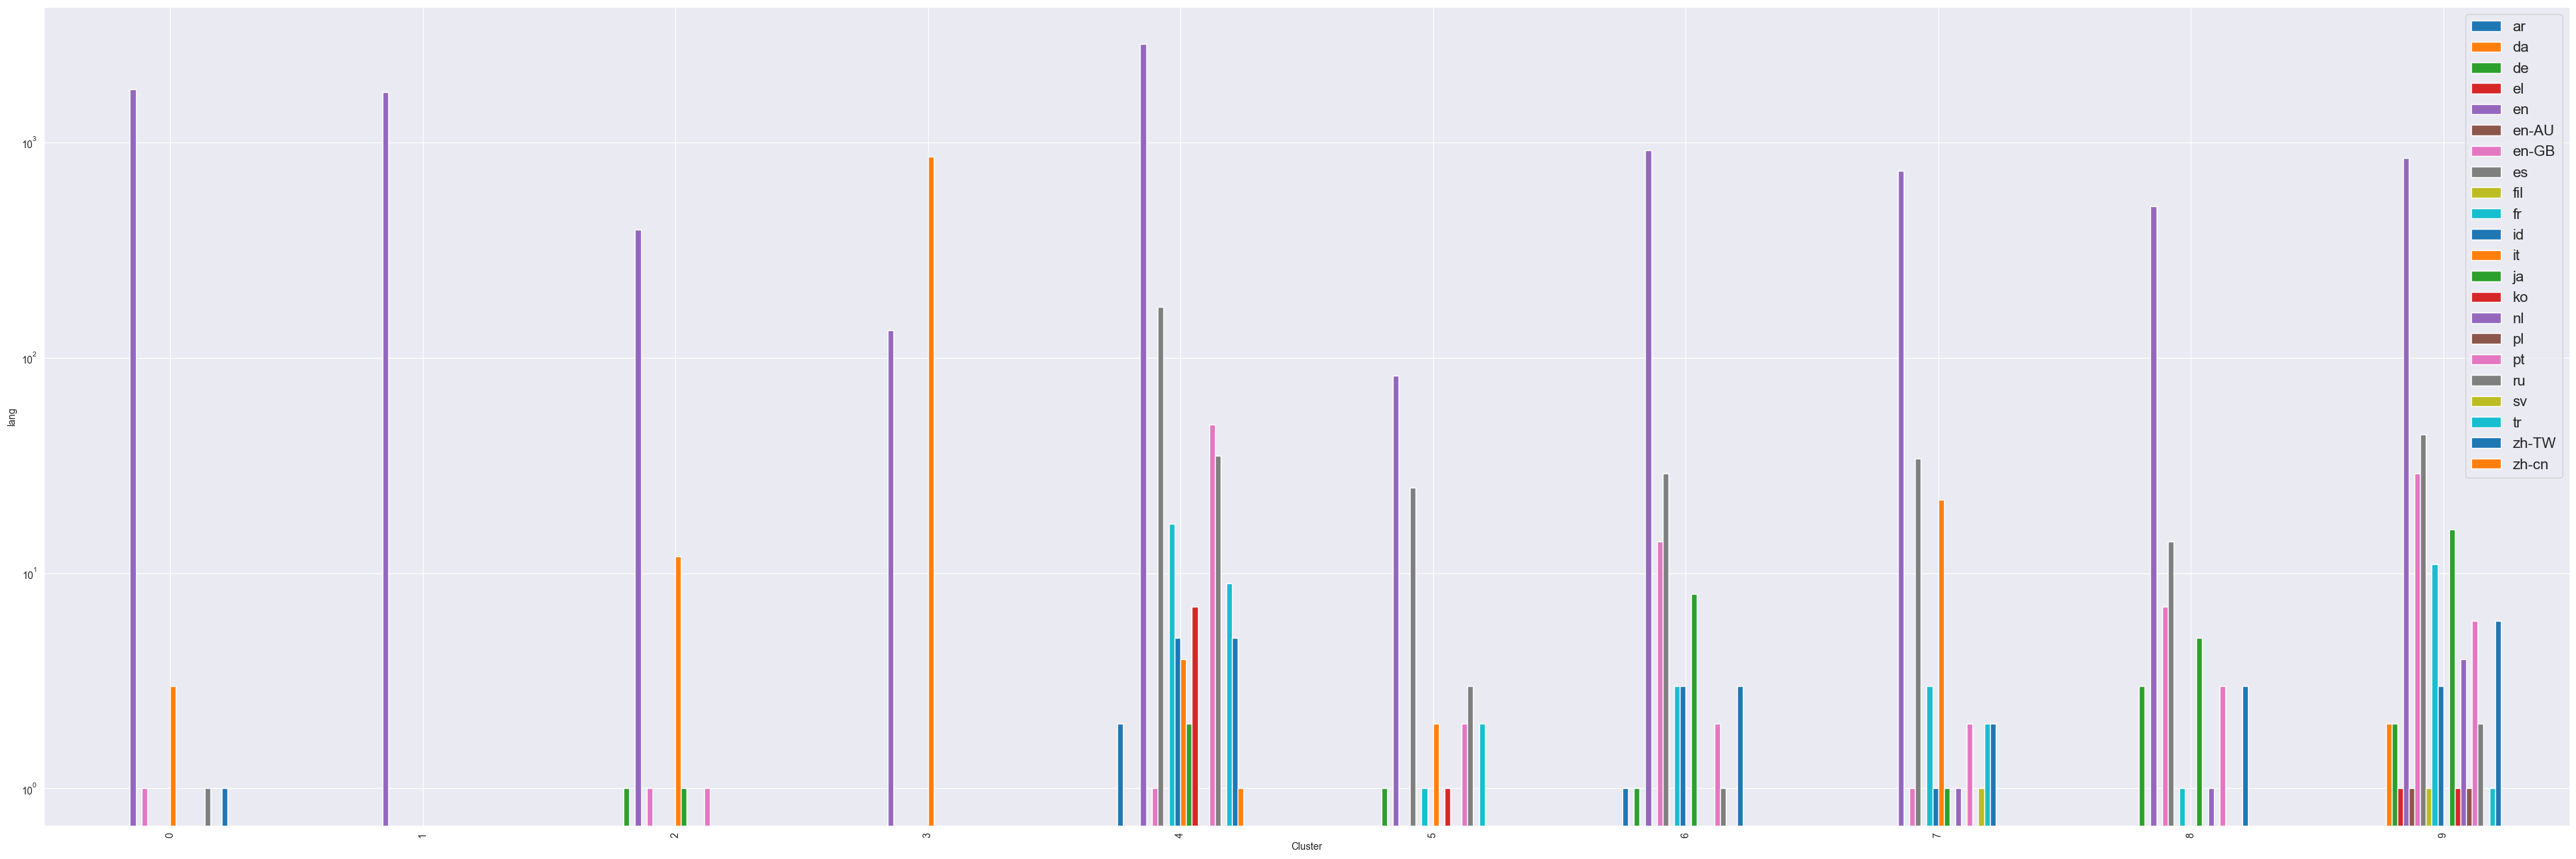

<Figure size 640x480 with 0 Axes>

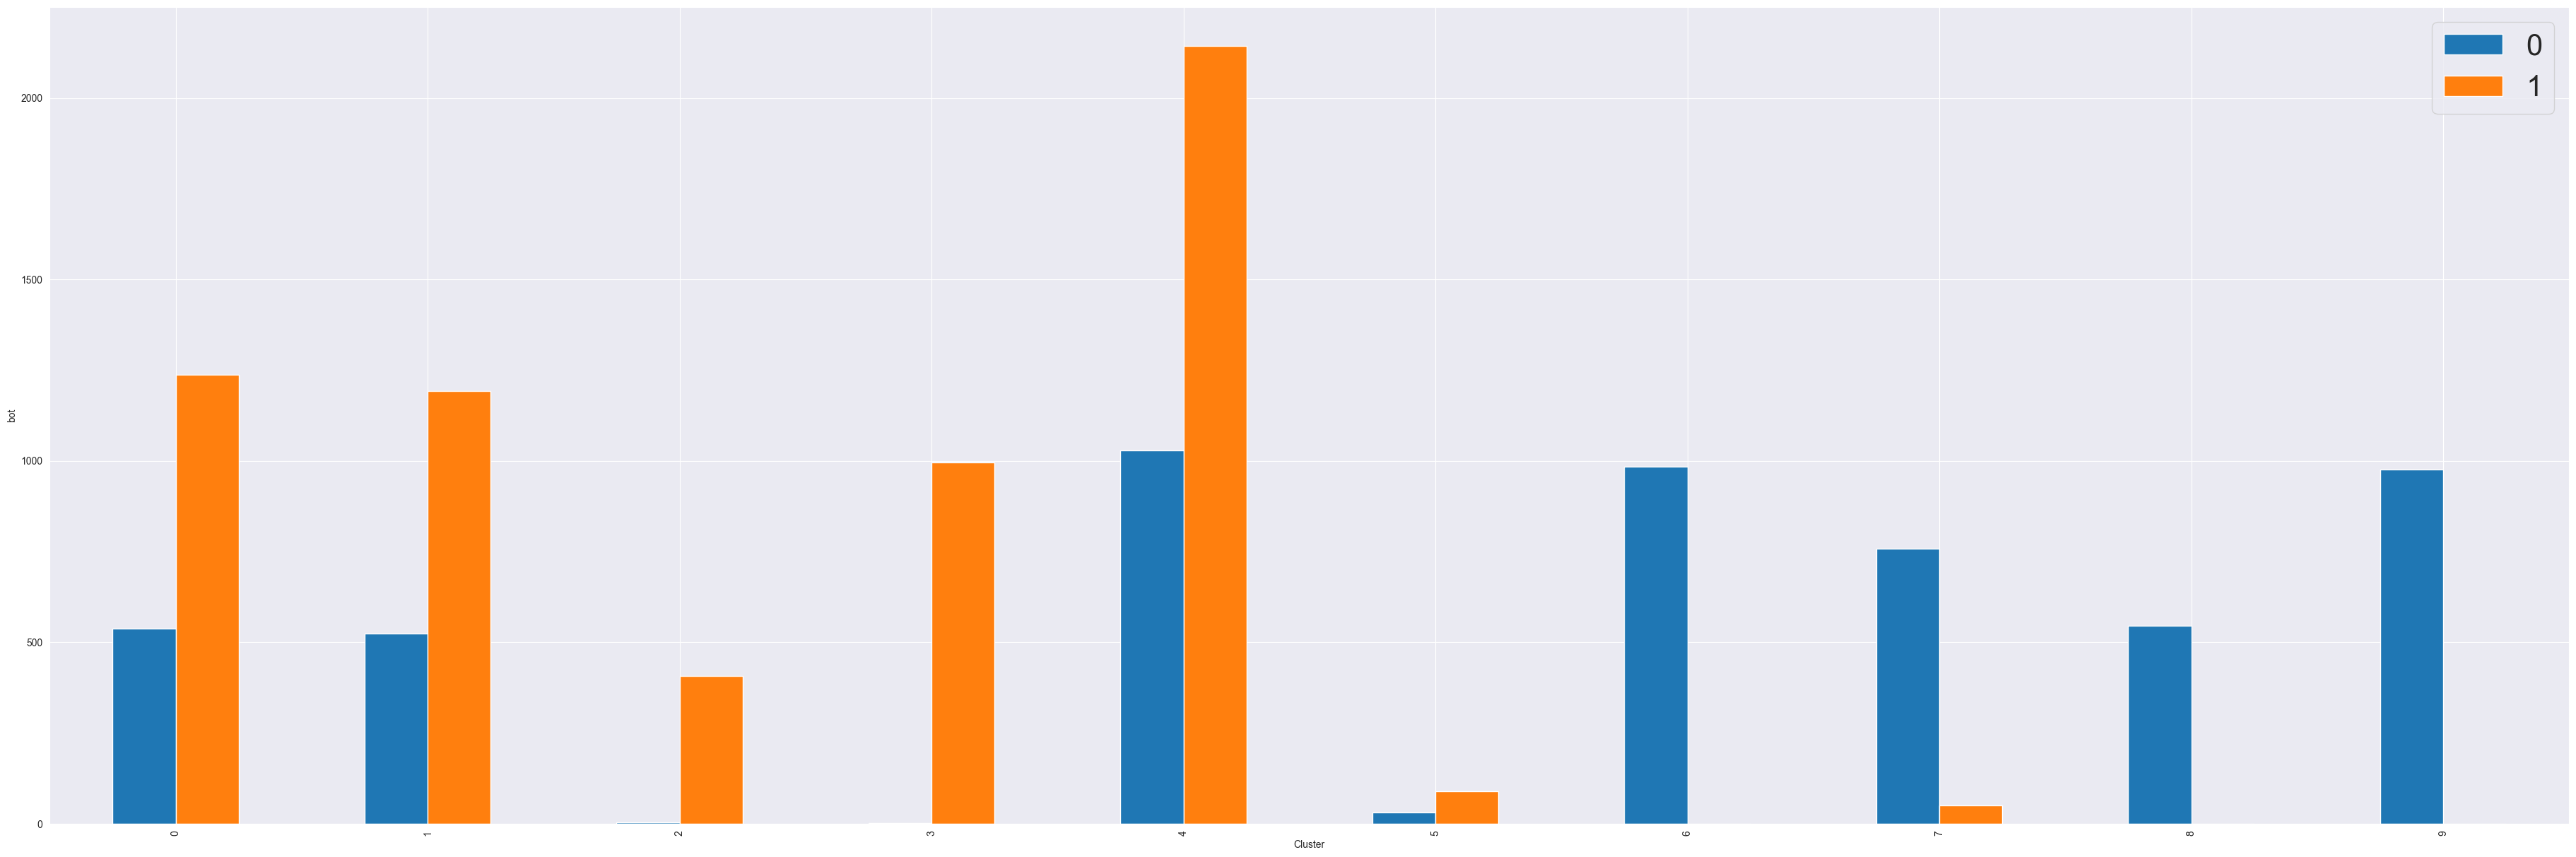

<Figure size 640x480 with 0 Axes>

In [62]:
plots(df_merge_scaled, np.array(list(cluster_labels.values())), path='xmeans', centroids=np.array(centroids), attributes = numeric_attributes)